In [1]:
######################################################################
# Author: Rohan Dahale, Date: 21 November 2024
######################################################################

# Import libraries
import numpy as np
import pandas as pd
import ehtim as eh
import ehtim.scattering.stochastic_optics as so
from preimcal import *
import tqdm
import copy
import matplotlib.pyplot as plt
import pdb
import argparse
import os
import glob
from utilities import *

import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Sans'


mpl.rcParams['figure.dpi']=300
plt.rcParams["xtick.direction"]="in"
plt.rcParams["ytick.direction"]="in"
    
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["legend.fontsize"] = 18
        
colors = {
            'truth'    : 'black',
            'kine'     : 'tab:blue',
            'resolve'  : 'tab:orange',
            'ehtim'    : 'tab:green',
            'doghit'   : 'tab:red',
            'ngmem'    : 'tab:purple',
            'modeling' : 'tab:brown' 
        }
    
titles = {  
        'truth'      : 'Truth',
        'kine'       : 'method 1',
        'resolve'    : 'method 2',
        'ehtim'      : 'method 3',
        'doghit'     : 'method 4',
        'ngmem'      : 'method 5',
        'modeling'   : 'method 6'
    }
    
labels = {  
        'truth'      : 'Truth',
        'kine'       : 'method 1',
        'resolve'    : 'method 2',
        'ehtim'      : 'method 3',
        'doghit'     : 'method 4',
        'ngmem'      : 'method 5',
        'modeling'   : 'method 6'
    }

mfcs = {
        'truth'    : 'none',
        'kine'     : 'tab:blue',
        'resolve'  : 'tab:orange',
        'ehtim'    : 'tab:green',
        'doghit'   : 'tab:red',
        'ngmem'    : 'tab:purple',
        'modeling' : 'tab:brown' 
    }

mss = {
            'truth'    : 10,
            'kine'     : 5,
            'resolve'  : 5,
            'ehtim'    : 5,
            'doghit'   : 5,
            'ngmem'    : 5,
            'modeling' : 5 
        }
    
codedir = os.getcwd()

basedir='/mnt/disks/shared/eht/sgra_dynamics_april11/DAR'

Welcome to eht-imaging! v 1.2.4 



'\n# Prepare data for the table\nmethods = [key for key in percent_pa.keys()]\ncategories = [\'PA (%)\', \'FWHM (%)\', \'Distance (%)\']\n\n# Create table data as rows\ntable_data = [\n    [f"{percent_pa[m]:.2f}" for m in methods],\n    [f"{percent_fwhm[m]:.2f}" for m in methods],\n    [f"{percent_dist[m]:.2f}" for m in methods],\n]\n\n# Create a figure and axis for the table\nfrom matplotlib.table import Table\n\n# Add a new subplot specifically for the table\nfig.subplots_adjust(bottom=0.2)  # Adjust space to fit table\ntable_ax = fig.add_axes([0.2, -0.1, 0.6, 0.2])  # Adjust placement\ntable_ax.axis("off")  # Turn off axis for the table\n\n# Add table\ntable = table_ax.table(\n    cellText=table_data,\n    rowLabels=categories,\n    colLabels=methods,\n    loc=\'center\',\n    cellLoc="center",\n)\n\n# Style the table\ntable.auto_set_font_size(False)\ntable.set_fontsize(14)\ntable.auto_set_column_width(col=list(range(len(methods) + 1)))\n'

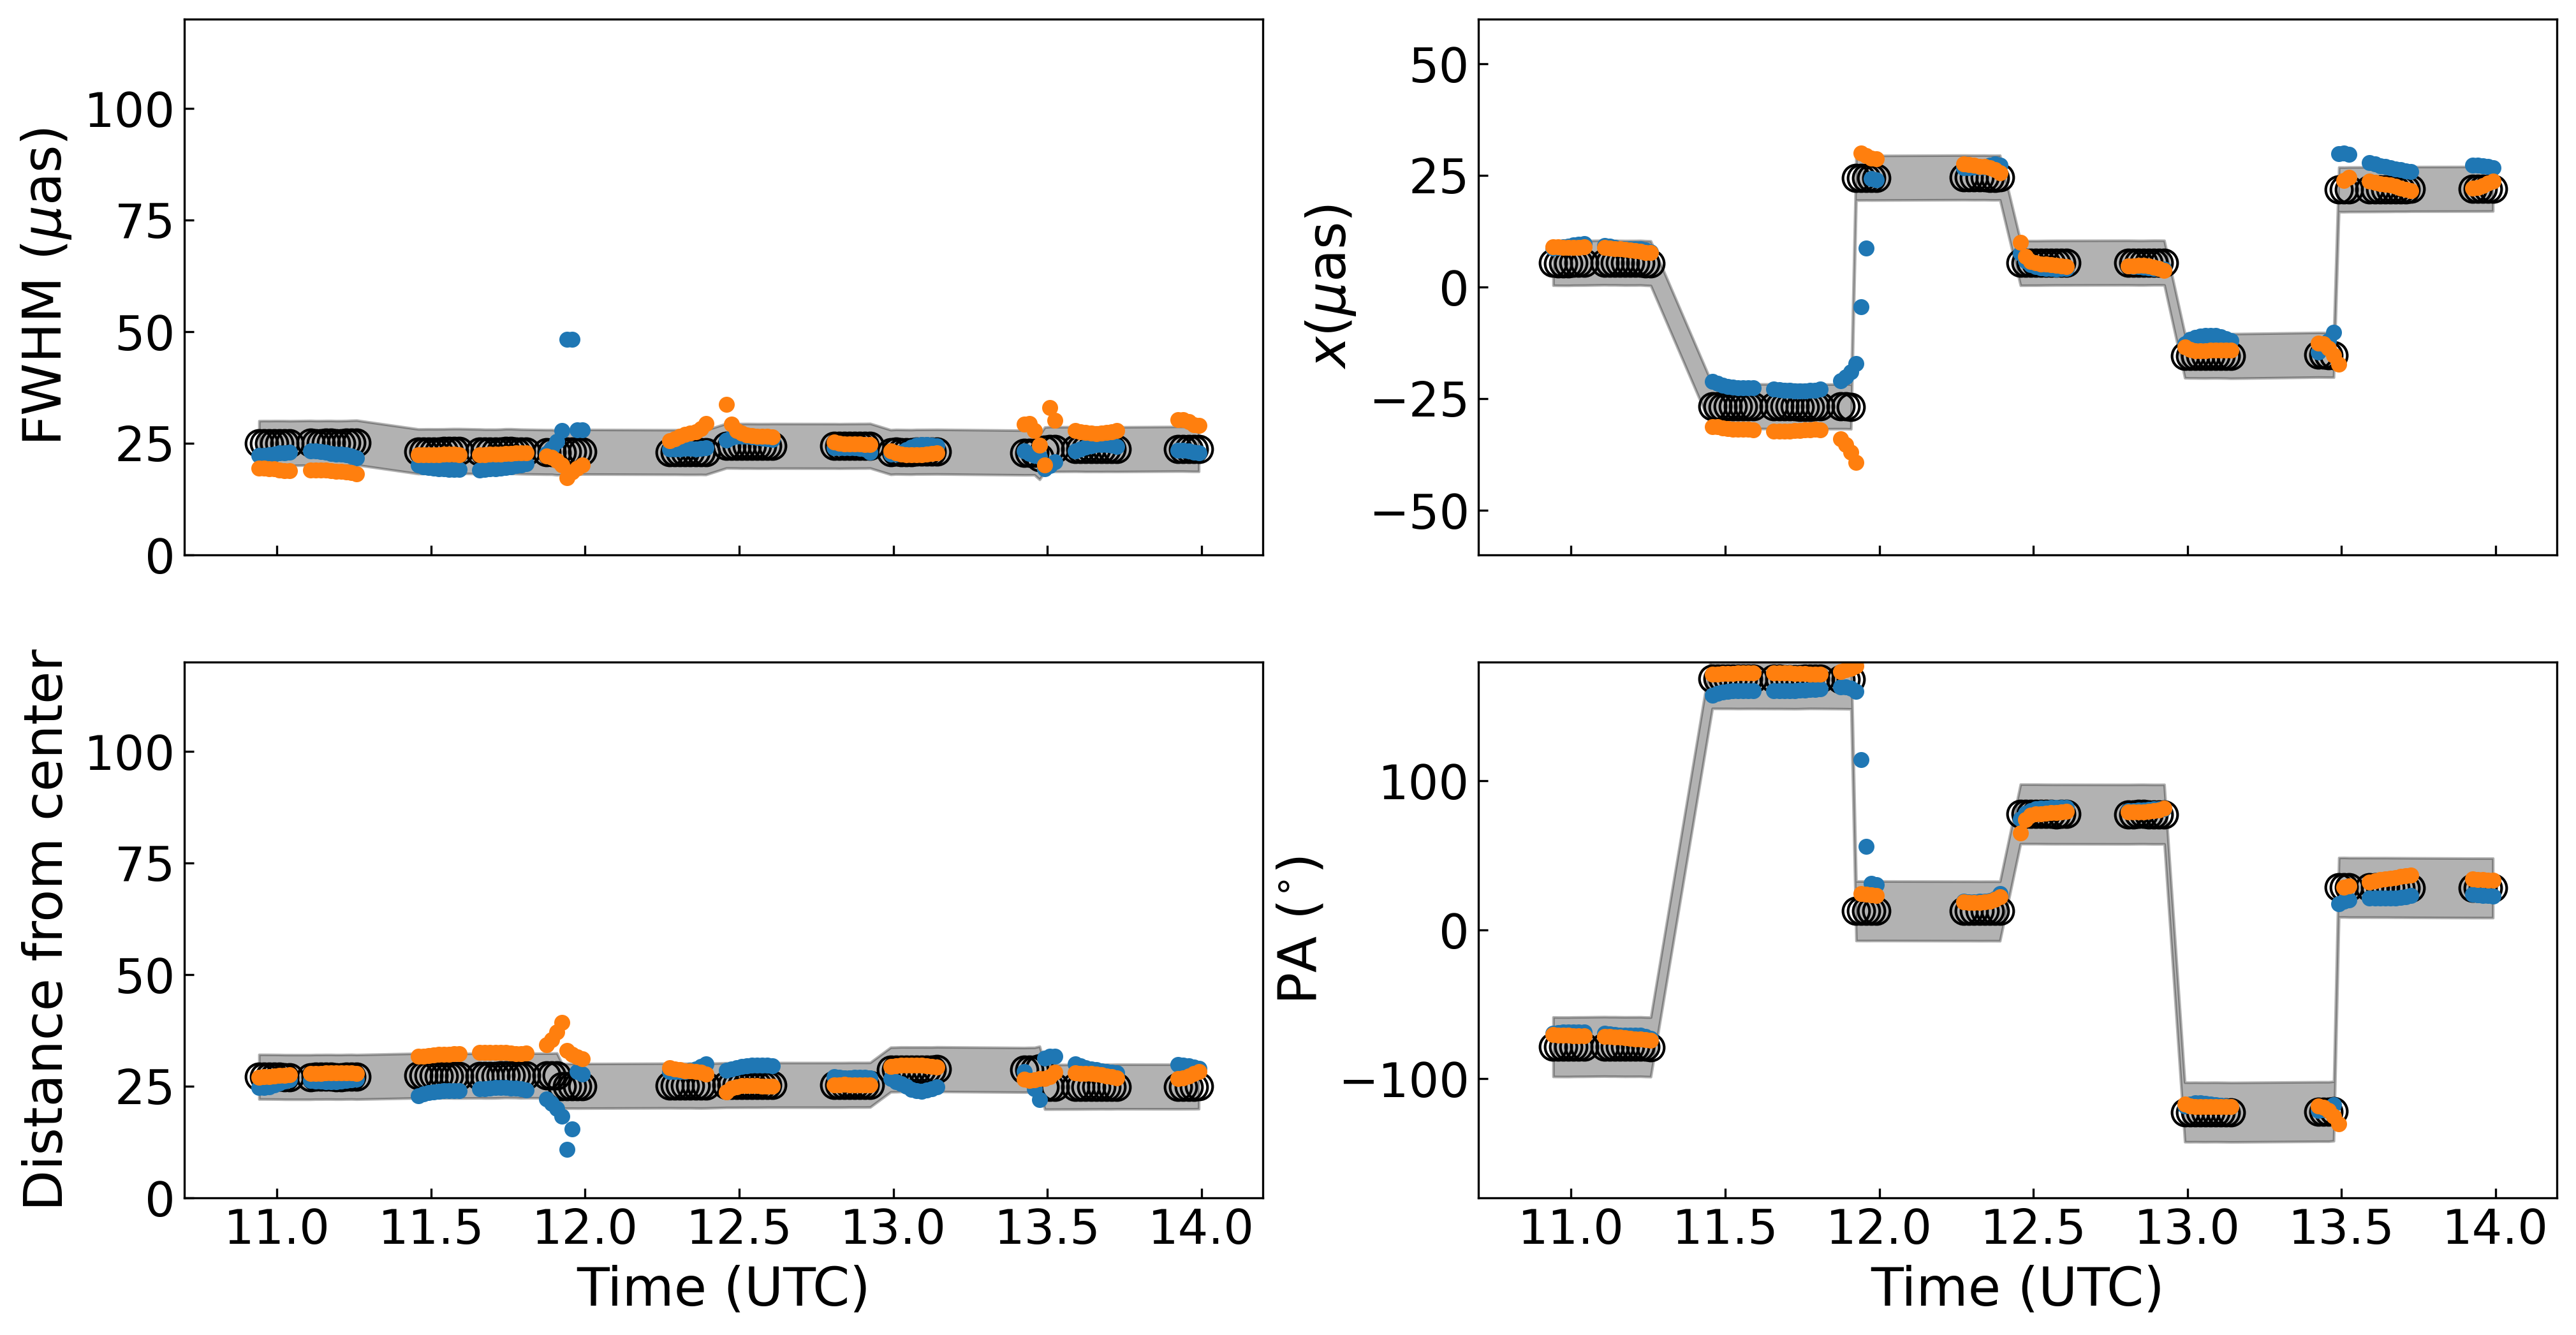

In [2]:
scat= 'onsky'

model = 'mring+hs-incoh'

data = f'{basedir}/submissons/{model}_LO_onsky.uvfits'

outpath = ''

outpath_csv={}
outpath_csv['truth'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_truth.csv'
outpath_csv['kine'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_kine.csv'
outpath_csv['resolve'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_resolve.csv'
#outpath_csv['ehtim'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ehtim.csv'
#outpath_csv['doghit'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_doghit.csv'
#outpath_csv['ngmem'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ngmem.csv'
#outpath_csv['modeling'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_modeling.csv'



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=True)
alpha=1.0
lc='grey'

ax[0,0].set_ylabel('FWHM ($\mu$as)')
ax[0,0].set_ylim(0,120)

ax[0,1].set_ylabel('$x (\mu$as)')
ax[0,1].set_ylim(-60,60)

ax[1,0].set_ylabel('Distance from center')
ax[1,0].set_ylim(0,120)
    
ax[1,1].set_ylabel(r'PA ($^{\circ}$)')
ax[1,1].set_ylim(-180,180)
ax[1,0].set_xlabel('Time (UTC)')
ax[1,1].set_xlabel('Time (UTC)')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(10.7,14.2)

######################################################################
# Read the CSV with extracted parameters
######################################################################
d1_dict={}
r0_dict={}
pa_dict={}
percent_pa = {}
percent_fwhm = {}
percent_dist = {}

pa_threshold = 20
fwhm_threshold = 5
dist_threshold = 5
x_threshold = 5

for p in outpath_csv.keys():
    df = pd.read_csv(outpath_csv[p])
        
    d1 = np.array(df['model_1_σ_1']/eh.RADPERUAS*(2*np.sqrt(2*np.log(2))))
    x01 = df['model_1_x0_1']/eh.RADPERUAS
    y01 = df['model_1_y0_1']/eh.RADPERUAS
        
    pos = df['model_1_x0_1']/eh.RADPERUAS + 1j*df['model_1_y0_1']/eh.RADPERUAS
    r0 = np.abs(pos)
    pa = np.rad2deg(np.angle(pos))
    t = df['time']

    mc=colors[p]
    mfc=mfcs[p]
    ms=mss[p]
    ax[0,0].plot(t, d1,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha, label=labels[p])
    ax[0,1].plot(t, x01, marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    ax[1,0].plot(t, r0,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    ax[1,1].plot(t, pa,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    
    if p == 'truth':
        ax[0,1].fill_between(t, x01 - x_threshold, x01 + x_threshold, color='black', alpha=0.3)
        truth_x = x01  # Store truth PA for comparison
        ax[1,1].fill_between(t, pa - pa_threshold, pa + pa_threshold, color='black', alpha=0.3)
        truth_pa = pa  # Store truth PA for comparison
        ax[1,0].fill_between(t, r0 - dist_threshold, r0 + dist_threshold, color='black', alpha=0.3)
        truth_dist = r0  # Store truth PA for comparison
        ax[0,0].fill_between(t, d1 - fwhm_threshold, d1 + fwhm_threshold, color='black', alpha=0.3)
        truth_fwhm = d1  # Store truth PA for comparison

    # Calculate percentage of values within threshold
    if p != 'truth':
        within_pa = (pa >= truth_pa - pa_threshold) & (pa <= truth_pa + pa_threshold)
        percentage = np.sum(within_pa) / len(pa) * 100
        percent_pa[p] = percentage
        
        within_dist = (r0 >= truth_dist - dist_threshold) & (r0 <= truth_dist + dist_threshold)
        percentage = np.sum(within_dist) / len(pa) * 100
        percent_dist[p] = percentage
        
        within_fwhm = (d1 >= truth_fwhm - fwhm_threshold) & (d1 <= truth_fwhm + fwhm_threshold)
        percentage = np.sum(within_fwhm) / len(pa) * 100
        percent_fwhm[p] = percentage

    d1_dict[p]=d1
    r0_dict[p]=r0
    pa_dict[p]=pa
        
#ax[0,0].legend(ncols=len(outpath_csv.keys()), loc='best',  bbox_to_anchor=(2.2, 1.2), markerscale=2.0, fontsize=12)
"""
# Prepare data for the table
methods = [key for key in percent_pa.keys()]
categories = ['PA (%)', 'FWHM (%)', 'Distance (%)']

# Create table data as rows
table_data = [
    [f"{percent_pa[m]:.2f}" for m in methods],
    [f"{percent_fwhm[m]:.2f}" for m in methods],
    [f"{percent_dist[m]:.2f}" for m in methods],
]

# Create a figure and axis for the table
from matplotlib.table import Table

# Add a new subplot specifically for the table
fig.subplots_adjust(bottom=0.2)  # Adjust space to fit table
table_ax = fig.add_axes([0.2, -0.1, 0.6, 0.2])  # Adjust placement
table_ax.axis("off")  # Turn off axis for the table

# Add table
table = table_ax.table(
    cellText=table_data,
    rowLabels=categories,
    colLabels=methods,
    loc='center',
    cellLoc="center",
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width(col=list(range(len(methods) + 1)))
"""
#plt.savefig(outpath+'.png', bbox_inches='tight', dpi=300)
#print(f'{os.path.basename(outpath)} is created')


'\n# Prepare data for the table\nmethods = [key for key in percent_pa.keys()]\ncategories = [\'X (%)\', \'X (%)\', \'FWHM (%)\', \'Distance (%)\']\n\n# Create table data as rows\ntable_data = [\n    [f"{percent_x[m]:.2f}" for m in methods],\n    [f"{percent_y[m]:.2f}" for m in methods],\n    [f"{percent_fwhm[m]:.2f}" for m in methods],\n    [f"{percent_dist[m]:.2f}" for m in methods],\n]\n\n# Create a figure and axis for the table\nfrom matplotlib.table import Table\n\n# Add a new subplot specifically for the table\nfig.subplots_adjust(bottom=0.2)  # Adjust space to fit table\ntable_ax = fig.add_axes([0.2, -0.1, 0.6, 0.2])  # Adjust placement\ntable_ax.axis("off")  # Turn off axis for the table\n\n# Add table\ntable = table_ax.table(\n    cellText=table_data,\n    rowLabels=categories,\n    colLabels=methods,\n    loc=\'center\',\n    cellLoc="center",\n)\n\n# Style the table\ntable.auto_set_font_size(False)\ntable.set_fontsize(14)\ntable.auto_set_column_width(col=list(range(len(method

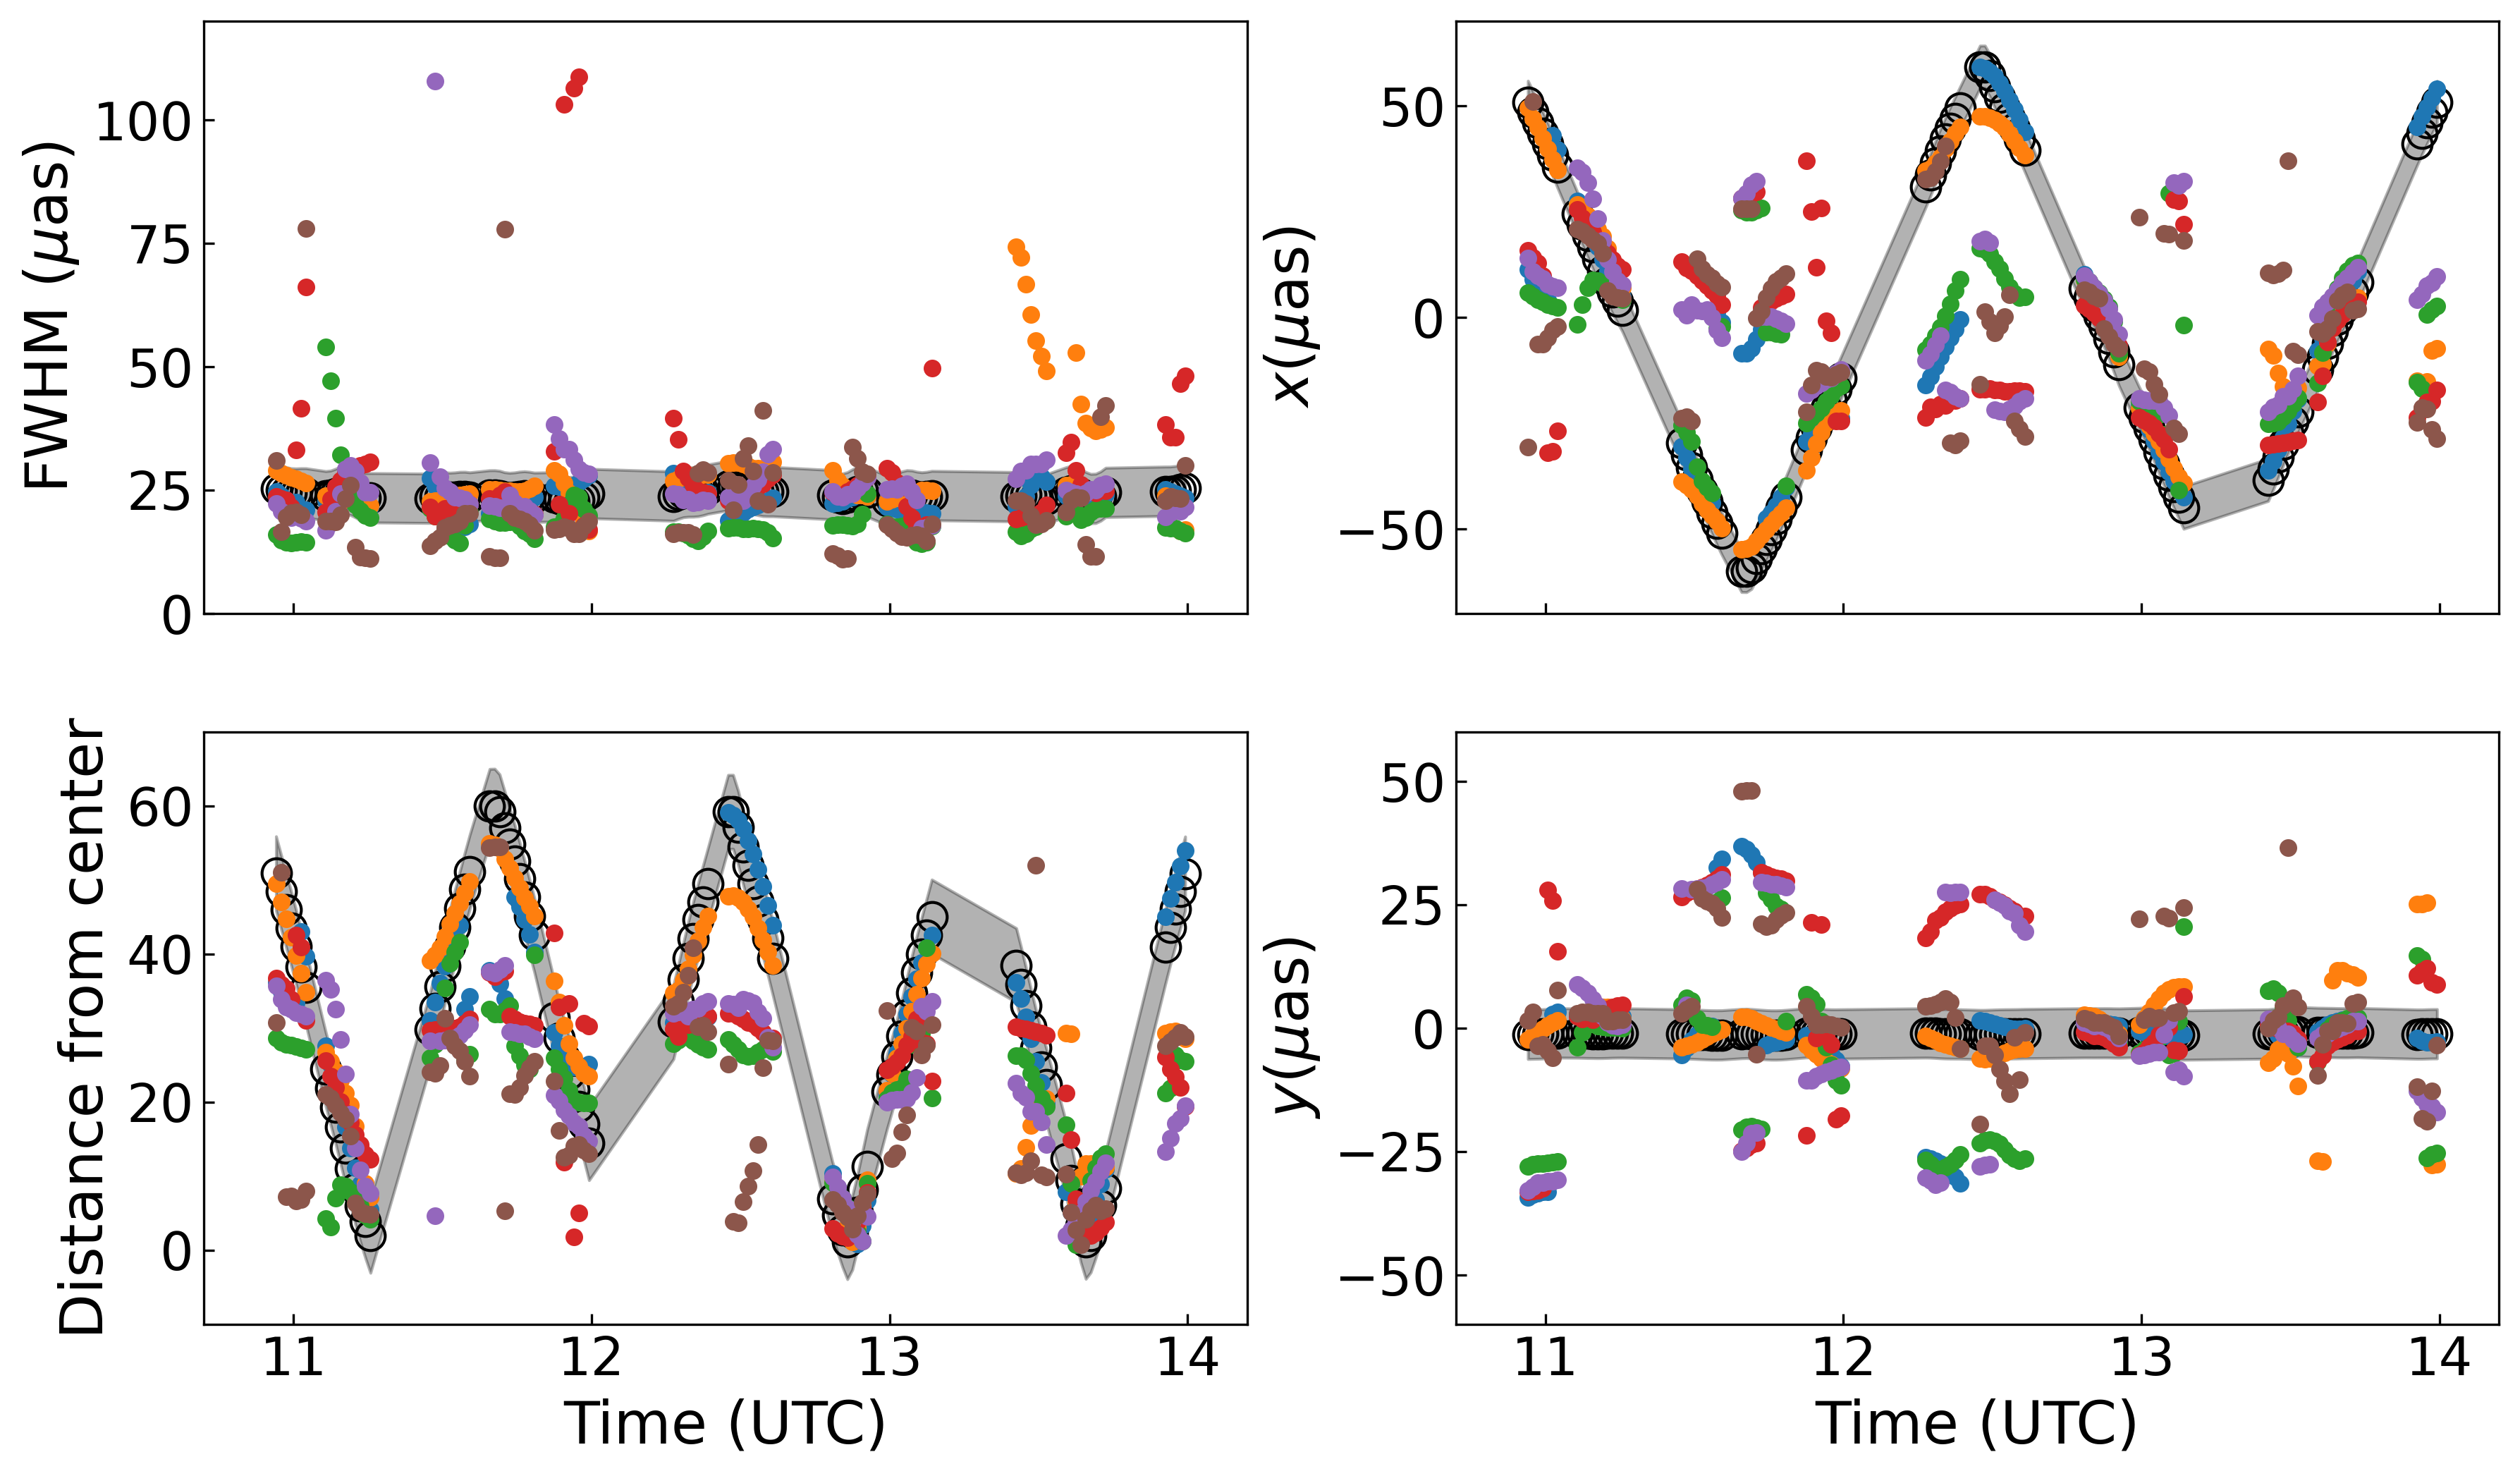

In [30]:
scat= 'onsky'

model = 'mring+hs-cross'

data = f'{basedir}/submissons/{model}_LO_onsky.uvfits'

outpath = ''

outpath_csv={}
outpath_csv['truth'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_truth.csv'
outpath_csv['kine'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_kine.csv'
outpath_csv['resolve'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_resolve.csv'
outpath_csv['ehtim'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ehtim.csv'
outpath_csv['doghit'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_doghit.csv'
outpath_csv['ngmem'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ngmem.csv'
outpath_csv['modeling'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_modeling.csv'



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8), sharex=True)
alpha=1.0
lc='grey'

ax[0,0].set_ylabel('FWHM ($\mu$as)')
ax[0,0].set_ylim(0,120)

ax[0,1].set_ylabel('$x (\mu$as)')
ax[0,1].set_ylim(-70,70)

ax[1,0].set_ylabel('Distance from center')
ax[1,0].set_ylim(-10,70)
    
ax[1,1].set_ylabel(r'$y (\mu$as)')
ax[1,1].set_ylim(-60,60)
ax[1,0].set_xlabel('Time (UTC)')
ax[1,1].set_xlabel('Time (UTC)')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(10.7,14.2)

######################################################################
# Read the CSV with extracted parameters
######################################################################
d1_dict={}
r0_dict={}
pa_dict={}

percent_x = {}
percent_y = {}
percent_fwhm = {}
percent_dist = {}

pa_threshold = 10
fwhm_threshold = 5
dist_threshold = 5
x_threshold = 5
y_threshold = 5

for p in outpath_csv.keys():
    df = pd.read_csv(outpath_csv[p])
        
    d1 = np.array(df['model_1_σ_1']/eh.RADPERUAS*(2*np.sqrt(2*np.log(2))))
    x01 = df['model_1_x0_1']/eh.RADPERUAS
    y01 = df['model_1_y0_1']/eh.RADPERUAS
        
    pos = df['model_1_x0_1']/eh.RADPERUAS + 1j*df['model_1_y0_1']/eh.RADPERUAS
    r0 = np.abs(pos)
    pa = np.rad2deg(np.angle(pos))
    t = df['time']

    mc=colors[p]
    mfc=mfcs[p]
    ms=mss[p]
    ax[0,0].plot(t, d1,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha, label=labels[p])
    ax[0,1].plot(t, x01, marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    ax[1,0].plot(t, r0,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    ax[1,1].plot(t, y01,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='none', lw=1, color=lc, alpha=alpha)
    
    if p == 'truth':
        ax[0,1].fill_between(t, x01 - x_threshold, x01 + x_threshold, color='black', alpha=0.3)
        truth_x = x01  # Store truth PA for comparison
        ax[1,1].fill_between(t, y01 - y_threshold, y01 + y_threshold, color='black', alpha=0.3)
        truth_y = y01  # Store truth PA for comparison
        ax[1,0].fill_between(t, r0 - dist_threshold, r0 + dist_threshold, color='black', alpha=0.3)
        truth_dist = r0  # Store truth PA for comparison
        ax[0,0].fill_between(t, d1 - fwhm_threshold, d1 + fwhm_threshold, color='black', alpha=0.3)
        truth_fwhm = d1  # Store truth PA for comparison

    # Calculate percentage of values within threshold
    if p != 'truth':
        within_x = (x01 >= truth_x - x_threshold) & (x01 <= truth_x + x_threshold)
        percentage = np.sum(within_x) / len(pa) * 100
        percent_x[p] = percentage
        
        within_y = (y01 >= truth_y - y_threshold) & (y01 <= truth_y + y_threshold)
        percentage = np.sum(within_y) / len(pa) * 100
        percent_y[p] = percentage
        
        within_dist = (r0 >= truth_dist - dist_threshold) & (r0 <= truth_dist + dist_threshold)
        percentage = np.sum(within_dist) / len(pa) * 100
        percent_dist[p] = percentage
        
        within_fwhm = (d1 >= truth_fwhm - fwhm_threshold) & (d1 <= truth_fwhm + fwhm_threshold)
        percentage = np.sum(within_fwhm) / len(pa) * 100
        percent_fwhm[p] = percentage

    d1_dict[p]=d1
    r0_dict[p]=r0
    pa_dict[p]=pa
        
#ax[0,0].legend(ncols=len(outpath_csv.keys()), loc='best',  bbox_to_anchor=(2.2, 1.2), markerscale=2.0, fontsize=12)

"""
# Prepare data for the table
methods = [key for key in percent_pa.keys()]
categories = ['X (%)', 'X (%)', 'FWHM (%)', 'Distance (%)']

# Create table data as rows
table_data = [
    [f"{percent_x[m]:.2f}" for m in methods],
    [f"{percent_y[m]:.2f}" for m in methods],
    [f"{percent_fwhm[m]:.2f}" for m in methods],
    [f"{percent_dist[m]:.2f}" for m in methods],
]

# Create a figure and axis for the table
from matplotlib.table import Table

# Add a new subplot specifically for the table
fig.subplots_adjust(bottom=0.2)  # Adjust space to fit table
table_ax = fig.add_axes([0.2, -0.1, 0.6, 0.2])  # Adjust placement
table_ax.axis("off")  # Turn off axis for the table

# Add table
table = table_ax.table(
    cellText=table_data,
    rowLabels=categories,
    colLabels=methods,
    loc='center',
    cellLoc="center",
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width(col=list(range(len(methods) + 1)))
"""

#plt.savefig(outpath+'.png', bbox_inches='tight', dpi=300)
#print(f'{os.path.basename(outpath)} is created')

Time to complete 360 degrees rotation for 'kine': 3.1523054947592066 hr
Time to complete 360 degrees rotation for 'resolve': 2.938582839777693 hr
Time to complete 360 degrees rotation for 'modeling': 3.283744576402246 h


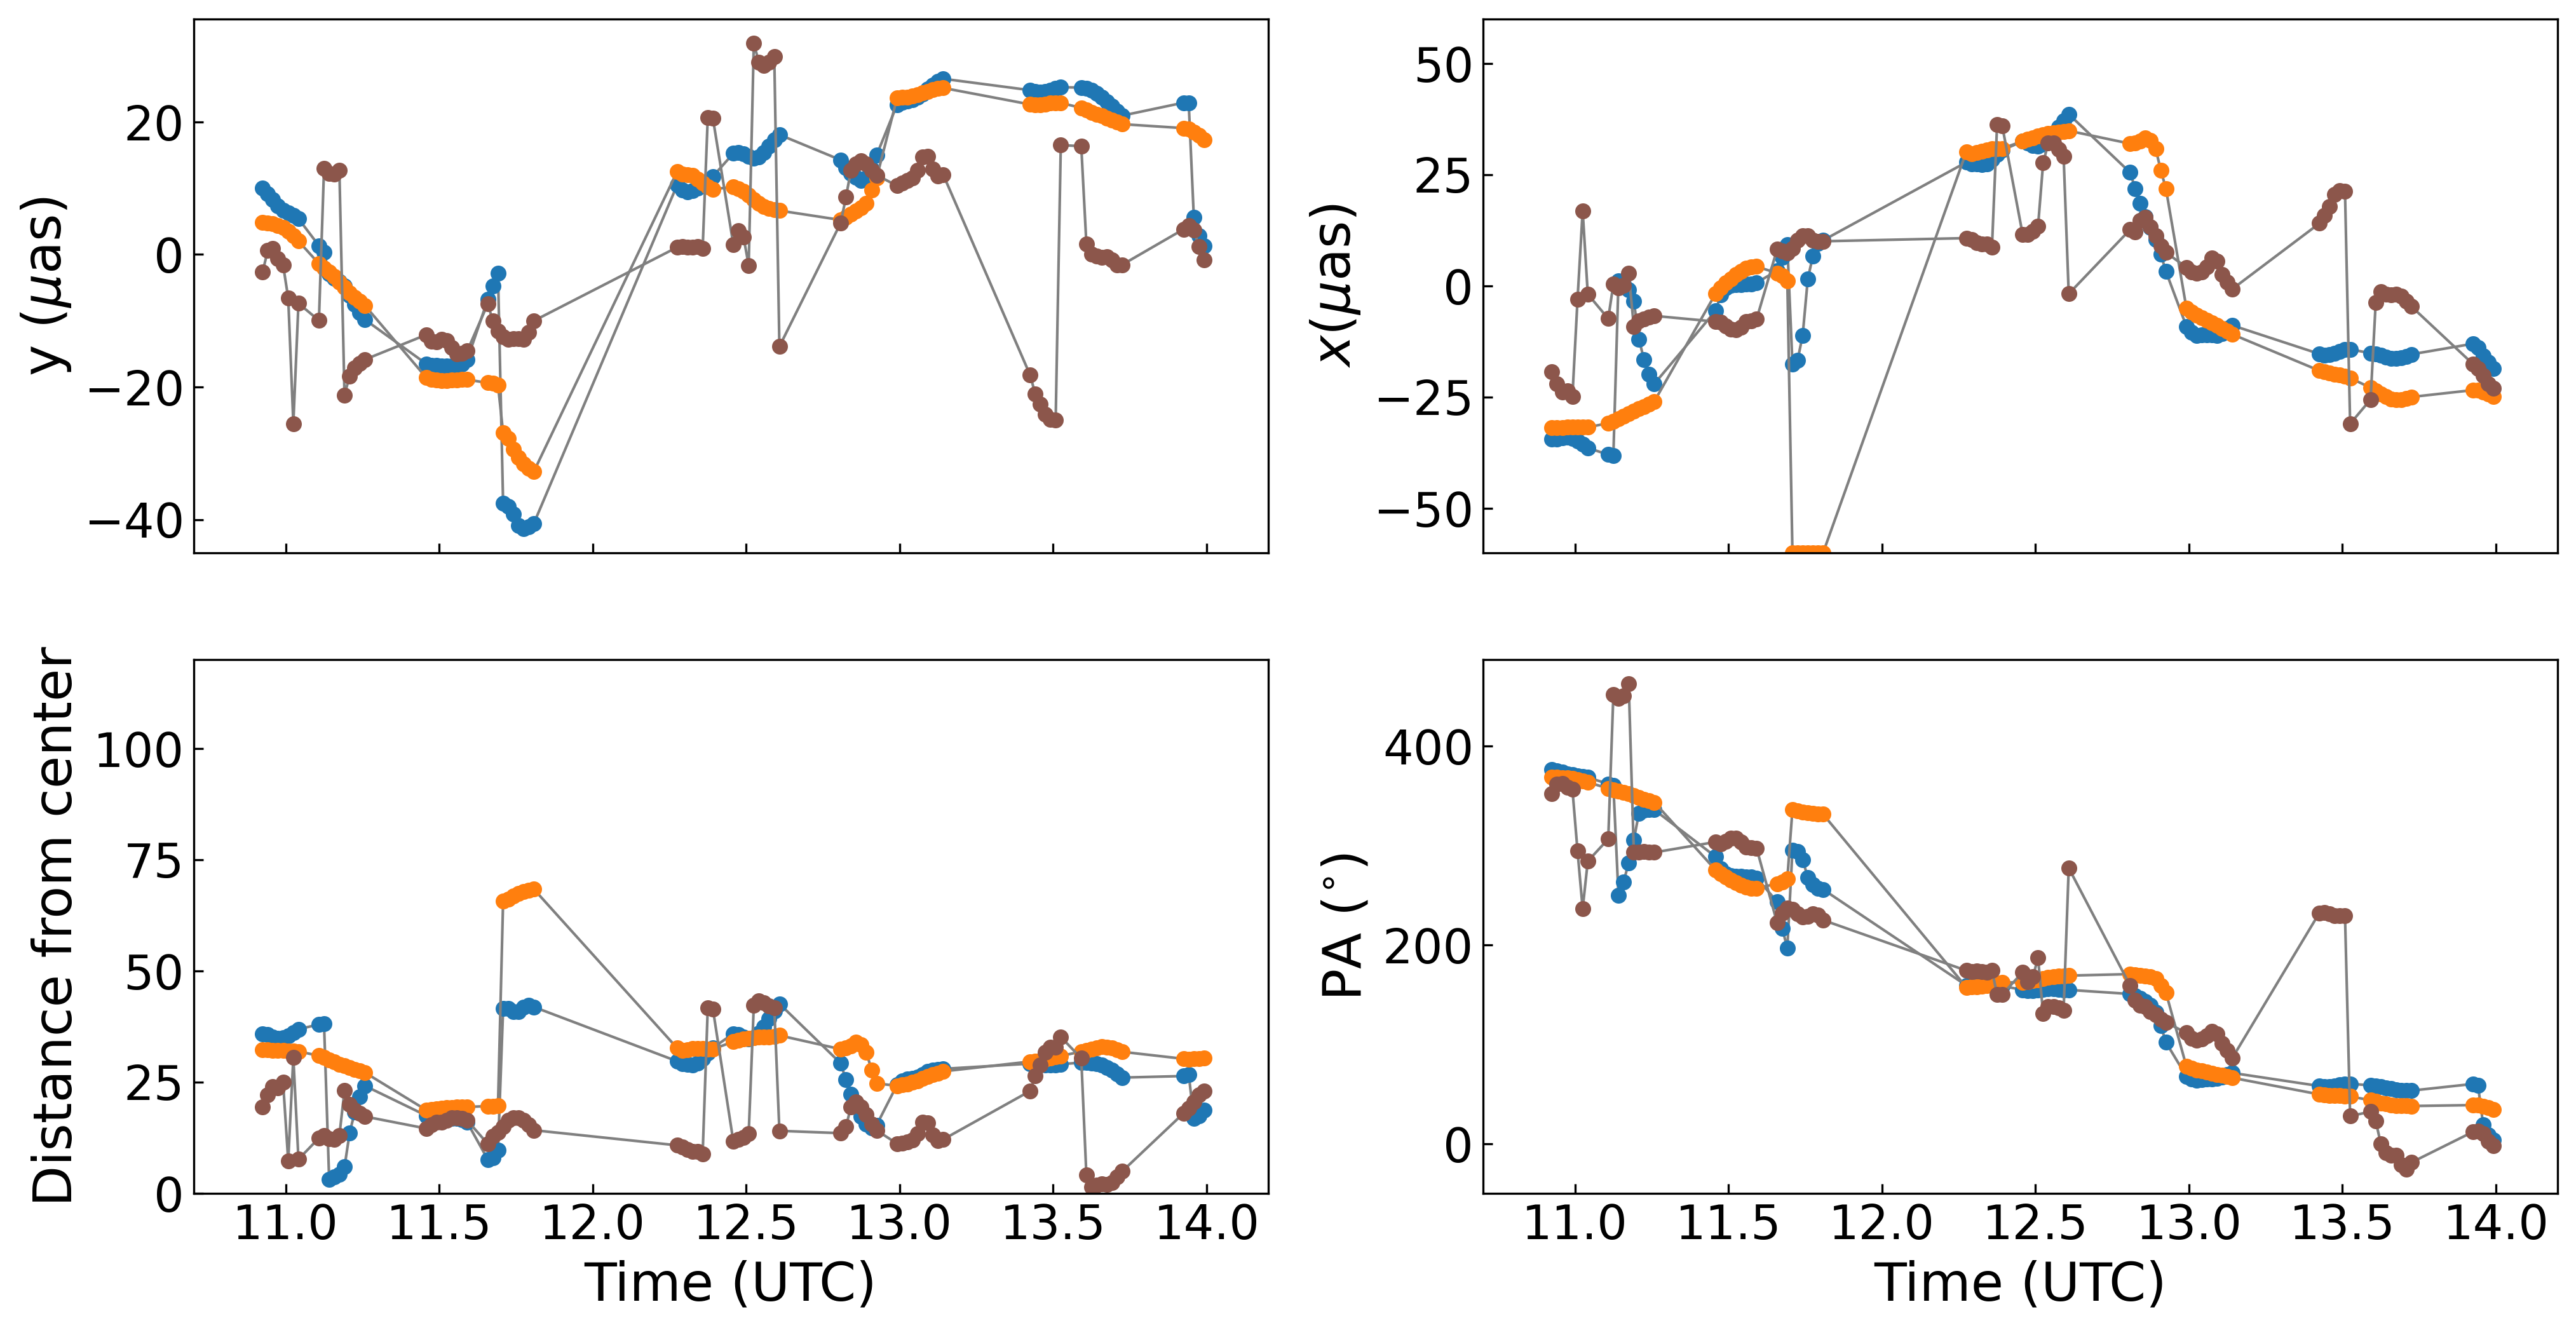

In [3]:
from scipy.stats import linregress

scat= 'onsky'

model = 'SGRA'

data = f'{basedir}/submissons/{model}_LO_onsky.uvfits'

outpath = ''

outpath_csv={}
#outpath_csv['truth'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_truth.csv'
outpath_csv['kine'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_kine.csv'
outpath_csv['resolve'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_resolve.csv'
#outpath_csv['ehtim'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ehtim.csv'
#outpath_csv['doghit'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_doghit.csv'
#outpath_csv['ngmem'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_ngmem.csv'
outpath_csv['modeling'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_modeling.csv'



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=True)
alpha=1.0
lc='grey'

ax[0,0].set_ylabel('y ($\mu$as)')
#ax[0,0].set_ylim(0,120)

ax[0,1].set_ylabel('$x (\mu$as)')
ax[0,1].set_ylim(-60,60)

ax[1,0].set_ylabel('Distance from center')
ax[1,0].set_ylim(0,120)
    
ax[1,1].set_ylabel(r'PA ($^{\circ}$)')
#ax[1,1].set_ylim(-180,180)
ax[1,0].set_xlabel('Time (UTC)')
ax[1,1].set_xlabel('Time (UTC)')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(10.7,14.2)
        
pa_dict={}
t_dict={}

for p in outpath_csv.keys():
    df = pd.read_csv(outpath_csv[p])
        
    d1 = np.array(df['model_1_σ_1']/eh.RADPERUAS*(2*np.sqrt(2*np.log(2))))
    x01 = df['model_1_x0_1']/eh.RADPERUAS
    y01 = df['model_1_y0_1']/eh.RADPERUAS
        
    pos = -df['model_1_x0_1']/eh.RADPERUAS +1j*df['model_1_y0_1']/eh.RADPERUAS
    r0 = np.abs(pos)
    pa = np.rad2deg(np.angle(pos))%360
    pa_dict[p]=pa
        
    t = df['time']
    t_dict[p]=t


    #if p!='modeling':
    #    for i in range(len(pa)):
    #        if 10.85<t[i]<11.1:
    #           pa[i] = pa[i] - 360
    #for i in range(1,len(pa)):
        #if pa[i] - pa[i-1] > 180:
        #    pa[i] = pa[i] - 360
        #if pa[i] - pa[i-1] < -180:
        #    pa[i] = pa[i] + 360
            
            
    mc=colors[p]
    mfc=mfcs[p]
    ms=mss[p]
    ax[0,0].plot(t, y01,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha, label=labels[p])
    ax[0,1].plot(t, x01, marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha)
    ax[1,0].plot(t, r0,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha)

for i in range(len(pa_dict['kine'])):
    if 10.85<t[i]<11.14:
        pa_dict['kine'][i] = pa_dict['kine'][i] + 360
ax[1,1].plot(t, pa_dict['kine'],  marker ='o', mfc=mfcs['kine'], mec=colors['kine'], ms=mss['kine'], ls='-', lw=1, color=lc, alpha=alpha)

for i in range(len(pa_dict['resolve'])):
    if 10.85<t[i]<11.1:
        pa_dict['resolve'][i] = pa_dict['resolve'][i] + 360
ax[1,1].plot(t, pa_dict['resolve'],  marker ='o', mfc=mfcs['resolve'], mec=colors['resolve'], ms=mss['resolve'], ls='-', lw=1, color=lc, alpha=alpha)

for i in range(len(pa_dict['modeling'])):
    if i==1:
        pa_dict['modeling'][i] = pa_dict['modeling'][i] + 360
    if i==2:
        pa_dict['modeling'][i] = pa_dict['modeling'][i] + 360
    if 11.12<t[i]<11.19:
        pa_dict['modeling'][i] = pa_dict['modeling'][i] + 360
    if 13.63<t[i]<13.75:
        pa_dict['modeling'][i] = pa_dict['modeling'][i] - 360
    if i==len(pa_dict['modeling'])-1:
        pa_dict['modeling'][i] = pa_dict['modeling'][i] - 360
ax[1,1].plot(t, pa_dict['modeling'],  marker ='o', mfc=mfcs['modeling'], mec=colors['modeling'], ms=mss['modeling'], ls='-', lw=1, color=lc, alpha=alpha)

import copy
dynamic_pa_dict = copy.deepcopy(pa_dict)
dynamic_pa_t_dict = copy.deepcopy(t_dict)

# Fit a line to the pa_dict['kine']
slope_kine, intercept_kine, r_value_kine, p_value_kine, std_err_kine = linregress(t, pa_dict['kine'])
# Calculate the time to complete 360 degrees rotation for 'kine'
time_to_rotate_kine = 360 / slope_kine

# Fit a line to the pa_dict['resolve']
slope_resolve, intercept_resolve, r_value_resolve, p_value_resolve, std_err_resolve = linregress(t, pa_dict['resolve'])
# Calculate the time to complete 360 degrees rotation for 'resolve'
time_to_rotate_resolve = 360 / slope_resolve

# Fit a line to the pa_dict['modeling']
slope_modeling, intercept_modeling, r_value_modeling, p_value_modeling, std_err_modeling = linregress(t, pa_dict['modeling'])
# Calculate the time to complete 360 degrees rotation for 'modeling'
time_to_rotate_modeling = 360 / slope_modeling

print(f"Time to complete 360 degrees rotation for 'kine': {-time_to_rotate_kine} hr")
print(f"Time to complete 360 degrees rotation for 'resolve': {-time_to_rotate_resolve} hr")
print(f"Time to complete 360 degrees rotation for 'modeling': {-time_to_rotate_modeling} h")

19.239051179550188
-22.520021706644357
263.7930065892511
-31.101894173783258
-27.739689272564654
54.260448992569025


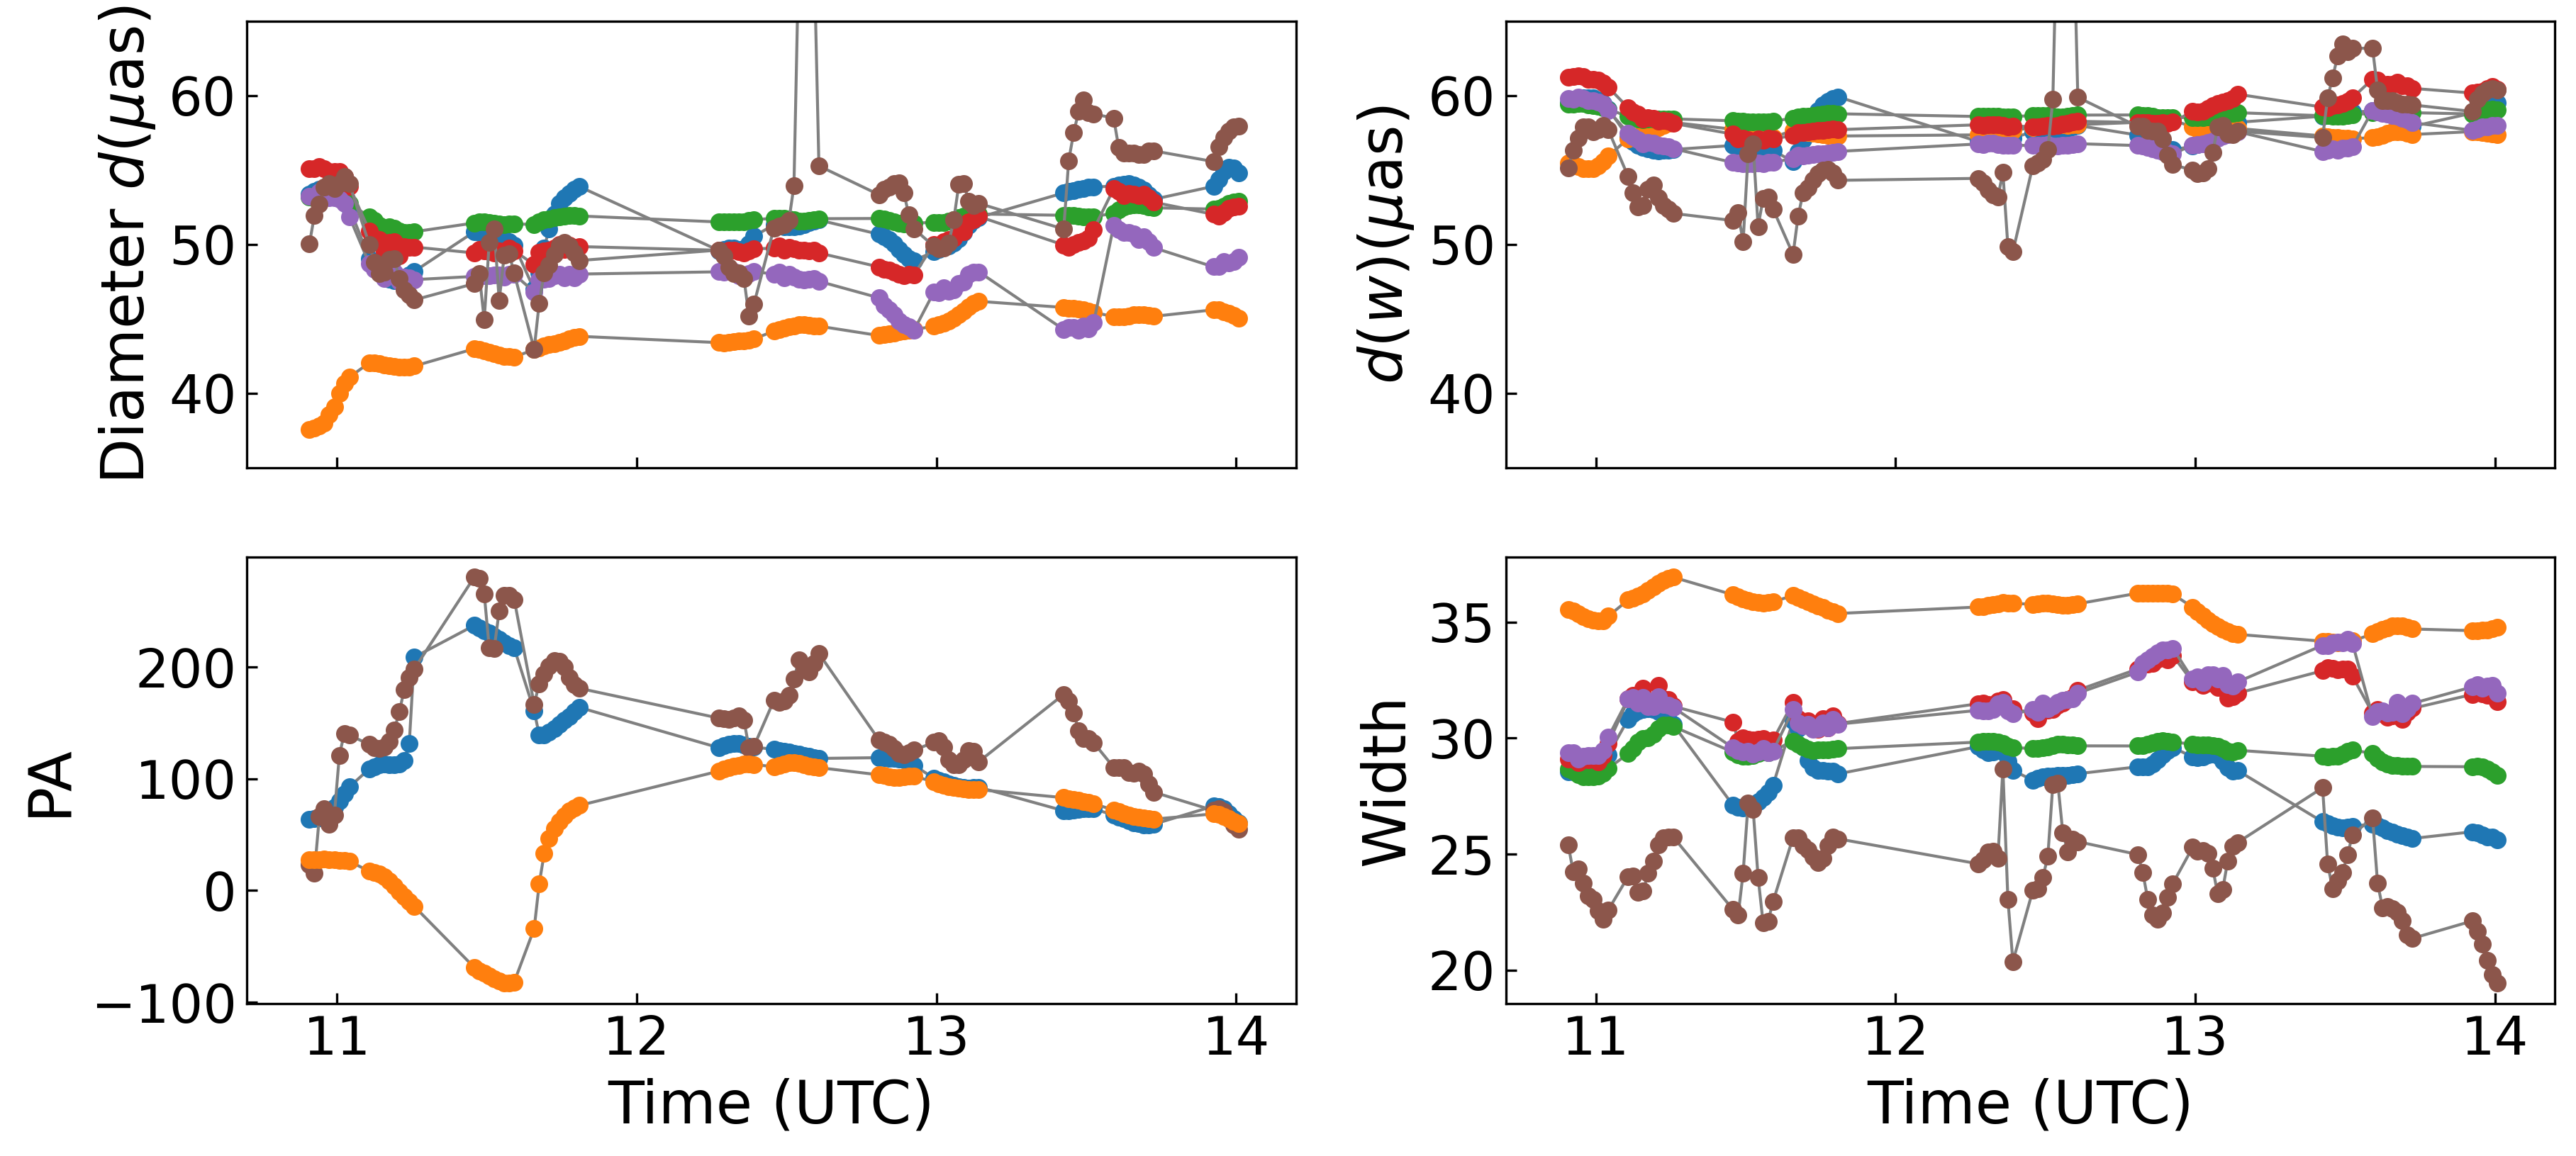

In [4]:

scat= 'onsky'

model = 'SGRA'

data = f'{basedir}/submissons/{model}_LO_onsky.uvfits'

outpath = ''

outpath_csv={}
#outpath_csv['truth'] = f'{basedir}/results/{model}_LO_onsky_dynamic_vida_truth.csv'
outpath_csv['kine'] = f'{basedir}/results/{model}_LO_onsky_vida_kine.csv'
outpath_csv['resolve'] = f'{basedir}/results/{model}_LO_onsky_vida_resolve.csv'
outpath_csv['ehtim'] = f'{basedir}/results/{model}_LO_onsky_vida_ehtim.csv'
outpath_csv['doghit'] = f'{basedir}/results/{model}_LO_onsky_vida_doghit.csv'
outpath_csv['ngmem'] = f'{basedir}/results/{model}_LO_onsky_vida_ngmem.csv'
outpath_csv['modeling'] = f'{basedir}/results/{model}_LO_onsky_vida_modeling.csv'



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,6), sharex=True)
alpha = 1.0
lc='grey'

ax[0,0].set_ylabel('Diameter $d (\mu$as)')
ax[0,0].set_ylim(35,65)

ax[0,1].set_ylabel('$d(w) (\mu$as)')
ax[0,1].set_ylim(35,65)

ax[1,0].set_ylabel('PA')
#ax[1,0].set_ylim(-180,180)

#ax[1,1].set_ylabel('Bright. Asym. $A$')
ax[1,1].set_ylabel('Width')
#ax[1,1].set_ylim(0.0,0.6)


ax[1,0].set_xlabel('Time (UTC)')
ax[1,1].set_xlabel('Time (UTC)')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(10.7,14.2)

######################################################################
# Read the CSV with extracted parameters
######################################################################
dw_dict={}
n_dict={}
a_dict={}
    
for p in outpath_csv.keys():
    df = pd.read_csv(outpath_csv[p])
    d = 2*df['model_1_r0']/eh.RADPERUAS
    w0 = df['model_1_σ0']/eh.RADPERUAS*(2*np.sqrt(2*np.log(2)))

    for i in range(len(df['model_1_ξs_1'])):
        if df['model_1_ξs_1'][i]<-np.pi:
            df['model_1_ξs_1'][i] = df['model_1_ξs_1'][i] + 2*np.pi
        if df['model_1_ξs_1'][i]>np.pi:
            df['model_1_ξs_1'][i] = df['model_1_ξs_1'][i] - 2*np.pi

    a = df['model_1_s_1']/2
    n =(np.rad2deg(df['model_1_ξs_1'])+90)%360
    t = df['time']
    
    pa_dict[p]=n

    mc=colors[p]
    mfc=mfcs[p]
    ms=mss[p]
        
    true_d=np.array(d/(1-(1/(4*np.log(2)))*(w0/d)**2))
        
    ax[0,0].plot(t, d,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha, label=labels[p])
    ax[0,1].plot(t, true_d, marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha)
    #ax[1,0].plot(t, n,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha)
    ax[1,1].plot(t, w0,  marker ='o', mfc=mfc, mec=mc, ms=ms, ls='-', lw=1, color=lc, alpha=alpha)
    
p='kine'
ax[1,0].plot(t, pa_dict[p],  marker ='o', mfc=mfcs[p], mec=colors[p], ms=mss[p], ls='-', lw=1, color=lc, alpha=alpha)
p='modeling'
ax[1,0].plot(t, pa_dict[p],  marker ='o', mfc=mfcs[p], mec=colors[p], ms=mss[p], ls='-', lw=1, color=lc, alpha=alpha)

p='resolve'
for i in range(len(pa_dict[p])):
    if 10.85<t[i]<11.20:
        pa_dict[p][i] = pa_dict[p][i] + 0
    if 11.2<t[i]<11.67:
        pa_dict[p][i] = pa_dict[p][i] -360
    if 11.67<t[i]<11.85:
        pa_dict[p][i] = pa_dict[p][i] + 0
        

ax[1,0].plot(t, pa_dict[p],  marker ='o', mfc=mfcs[p], mec=colors[p], ms=mss[p], ls='-', lw=1, color=lc, alpha=alpha)

import scipy
print(scipy.stats.circmean(pa_dict['kine']%360, high=360, low=0)-90)
print(scipy.stats.circmean(pa_dict['resolve']%360, high=360, low=0)-90)
print(scipy.stats.circmean(pa_dict['ehtim']%360, high=360, low=0)-90)
print(scipy.stats.circmean(pa_dict['doghit']%360, high=360, low=0)-90)
print(scipy.stats.circmean(pa_dict['ngmem']%360, high=360, low=0)-90)
print(scipy.stats.circmean(pa_dict['modeling']%360, high=360, low=0)-90)

import copy
overall_pa_dict = copy.deepcopy(pa_dict)

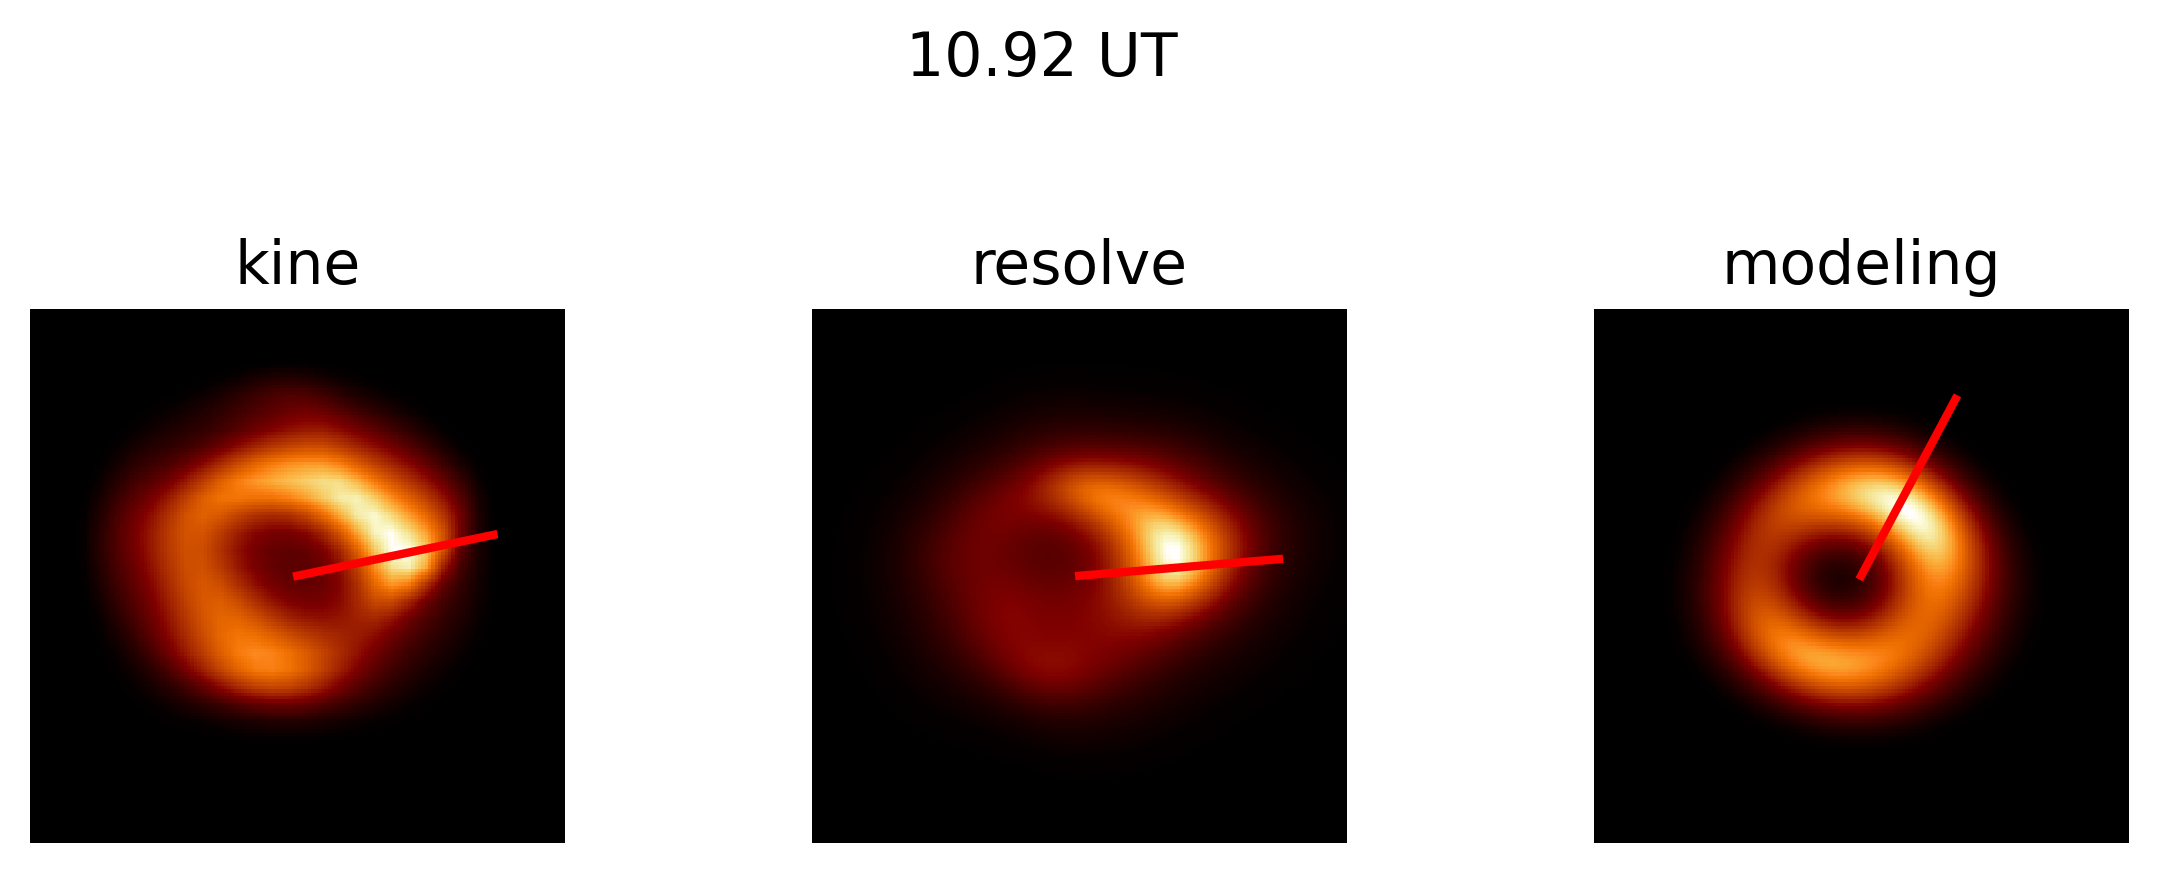

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ehtim as eh
import ehtplot

#obs = eh.obsdata.load_uvfits('/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky.uvfits')
time_array = dynamic_pa_t_dict['kine'] #np.linspace(10.9, 14.03, 100)

# Create a sample image for the background
kine='/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky_kine.hdf5'
resolve = '/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO+HI_onsky_resolve_mean.hdf5'
modeling = '/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky_modeling_mean.hdf5'

mvk = eh.movie.load_hdf5(kine)
mvr = eh.movie.load_hdf5(resolve)
mvm = eh.movie.load_hdf5(modeling)

datak = [mvk.get_image(t).regrid_image(160*eh.RADPERUAS,160).imarr() for t in time_array]
datar = [mvr.get_image(t).regrid_image(160*eh.RADPERUAS,160).imarr() for t in time_array]
datam = [mvm.get_image(t).regrid_image(160*eh.RADPERUAS,160).imarr() for t in time_array]

rotation_speed_k = -0.61/20.4  # Degrees per second
rotation_speed_r = -0.65/20.4  # Degrees per second
rotation_speed_m = -0.66/20.4  # Degrees per second

# Compute cumulative angles based on time differences
angles_k = np.cumsum(np.diff(time_array*3600, prepend=time_array[0]*3600) * rotation_speed_k)
angles_r = np.cumsum(np.diff(time_array*3600, prepend=time_array[0]*3600) * rotation_speed_r)
angles_m = np.cumsum(np.diff(time_array*3600, prepend=time_array[0]*3600) * rotation_speed_m)

vmin=np.min(datak)
vmax=np.max(datak)

from scipy.ndimage import gaussian_filter1d

dynamic_pa_dict['kine'] = gaussian_filter1d(dynamic_pa_dict['kine'], sigma=5)
dynamic_pa_dict['resolve'] = gaussian_filter1d(dynamic_pa_dict['kine'], sigma=5)
dynamic_pa_dict['modeling'] = gaussian_filter1d(dynamic_pa_dict['kine'], sigma=5)

def update(frame):
    # Clear the current figure
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    # Display the image
    ax[0].imshow(datak[frame], cmap='afmhot_us', extent=(-1, 1, -1, 1))
    ax[1].imshow(datar[frame], cmap='afmhot_us', extent=(-1, 1, -1, 1))
    ax[2].imshow(datam[frame], cmap='afmhot_us', extent=(-1, 1, -1, 1))
    
    # Calculate the angle of the line for the current frame
    #angle_rad = np.radians(angles_k[frame])
    #x =0.75*np.cos(angle_rad)
    #y = 0.75*np.sin(angle_rad)
    #ax[0].plot([0, x], [0, y], color='green', linewidth=2)
    #angle_rad = np.radians(overall_pa_dict['kine'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[0].plot([0, x], [0, y], color='blue', linewidth=2)
    #angle_rad = np.radians(dynamic_pa_dict['kine'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[0].plot([0, x], [0, y], color='purple', linewidth=2)
    angle_rad = np.radians(peak_pa_dict['kine'][frame]+90)
    x = 0.75 * np.cos(angle_rad)
    y = 0.75 * np.sin(angle_rad)
    ax[0].plot([0, x], [0, y], color='red', linewidth=2)
    
    
    

    #angle_rad = np.radians(angles_r[frame])
    #x =0.75*np.cos(angle_rad)
    #y = 0.75*np.sin(angle_rad)    
    #ax[1].plot([0, x], [0, y], color='green', linewidth=2)
    #angle_rad = np.radians(overall_pa_dict['resolve'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[1].plot([0, x], [0, y], color='blue', linewidth=2)
    #angle_rad = np.radians(dynamic_pa_dict['resolve'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[1].plot([0, x], [0, y], color='purple', linewidth=2)
    angle_rad = np.radians(peak_pa_dict['resolve'][frame]+90)
    x = 0.75 * np.cos(angle_rad)
    y = 0.75 * np.sin(angle_rad)
    ax[1].plot([0, x], [0, y], color='red', linewidth=2)
    
    
    
    #angle_rad = np.radians(angles_m[frame])
    #x =0.75*np.cos(angle_rad)
    #y = 0.75*np.sin(angle_rad)    
    #ax[2].plot([0, x], [0, y], color='green', linewidth=2)
    #angle_rad = np.radians(overall_pa_dict['modeling'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[2].plot([0, x], [0, y], color='blue', linewidth=2)
    #angle_rad = np.radians(dynamic_pa_dict['modeling'][frame])
    #x = 0.75 * np.cos(angle_rad)
    #y = 0.75 * np.sin(angle_rad)
    #ax[2].plot([0, x], [0, y], color='purple', linewidth=2)
    angle_rad = np.radians(peak_pa_dict['modeling'][frame]+90)
    x = 0.75 * np.cos(angle_rad)
    y = 0.75 * np.sin(angle_rad)
    ax[2].plot([0, x], [0, y], color='red', linewidth=2)
    
    # Set limits and turn off axes for better display
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    ax[0].set_title('kine')
    ax[0].axis('off')
    
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    ax[1].set_title('resolve')
    ax[1].axis('off')
    
    ax[2].set_xlim(-1, 1)
    ax[2].set_ylim(-1, 1)
    ax[2].set_title('modeling')
    ax[2].axis('off')
    plt.suptitle(f'{time_array[frame]:.2f} UT')

# Create a figure and axis
def linear_interpolation(x, x1, y1, x2, y2):
    return y1 + (y2 - y1) * (x - x1) / (x2 - x1)
num_subplots=3
#figsize=(linear_interpolation(num_subplots, 2, 8, 7, 16),linear_interpolation(num_subplots, 2, 4, 7, 3))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace=0.0, top=0.8, bottom=0.01, left=0.01, right=0.99)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(time_array), interval=500)
fig.tight_layout()
output_file = "peak_pa.gif"
ani.save(output_file, writer="ffmpeg", fps=10)
# Display the animation
#plt.show()

In [25]:
d = 1.0686138662148263e-10/eh.RADPERUAS*2
w0 = 7.555622285709914e-11/eh.RADPERUAS*2
true_d=d/(1-(1/(4*np.log(2)))*(w0/d)**2)
pa = np.rad2deg(-0.4376628659682935)
print(true_d, w0, pa)

53.7805067126884 31.169179336771844 -25.076235069583046


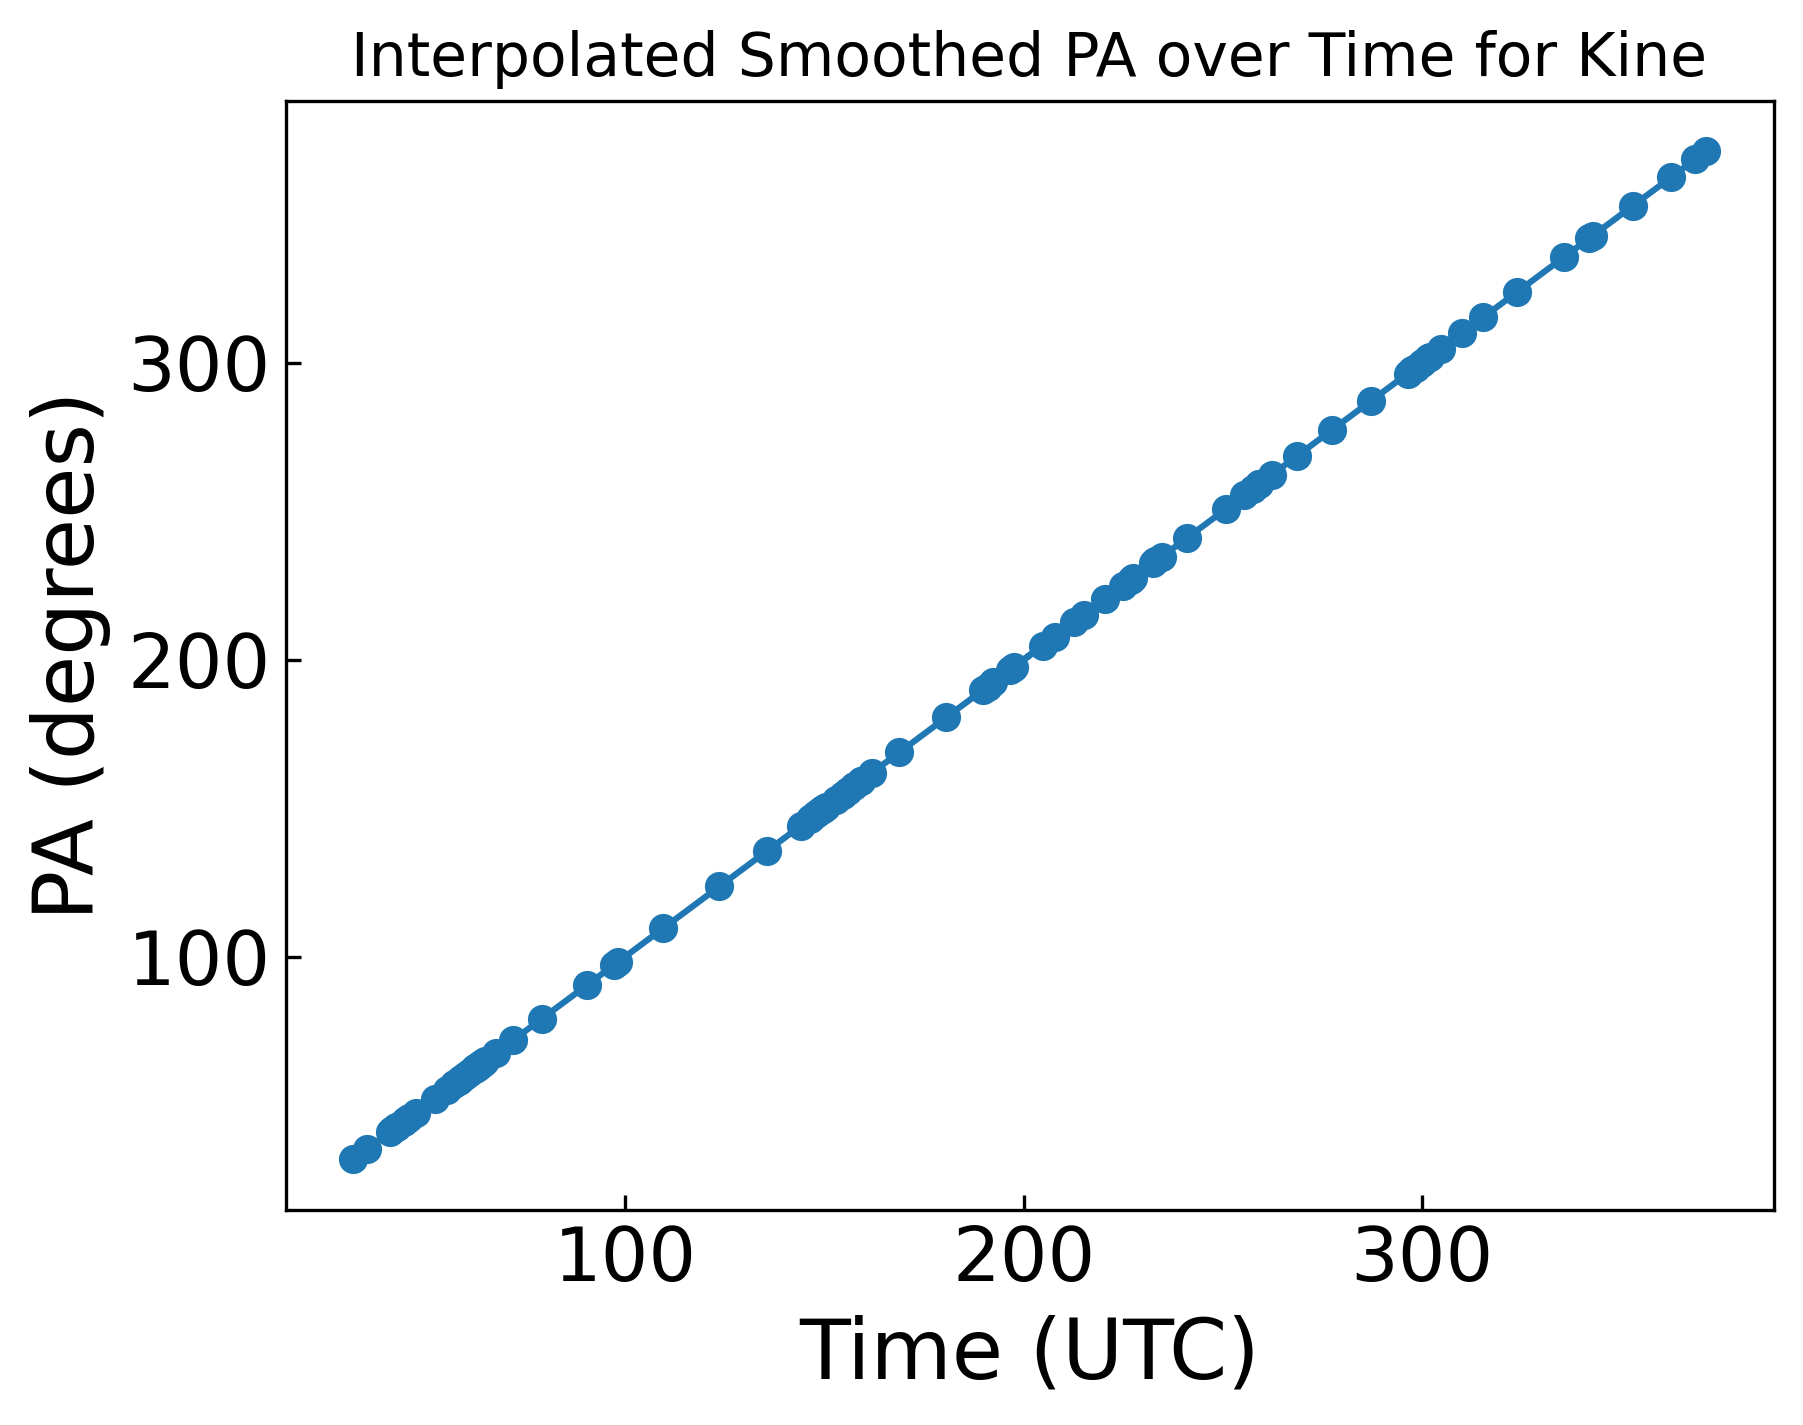

In [99]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Apply Gaussian filter to smooth the data
smoothed_pa_kine = gaussian_filter1d(dynamic_pa_dict['kine'], sigma=4)

# Create an interpolation function
interp_func = interp1d(dynamic_pa_t_dict['kine'], smoothed_pa_kine, kind='cubic')

# Define the new time array for interpolation
new_time_array = np.linspace(10.93, 13.99, 100)

# Interpolate the smoothed PA values
new_time_array = interp_func(new_time_array)

# Plot the interpolated data
plt.plot(new_time_array, new_time_array, '-o')
plt.xlabel('Time (UTC)')
plt.ylabel('PA (degrees)')
plt.title('Interpolated Smoothed PA over Time for Kine')
plt.show()

In [26]:
d = 1.2656538932623145e-10/eh.RADPERUAS*2
w0 = 6.144995258005943e-11/eh.RADPERUAS*2
true_d=d/(1-(1/(4*np.log(2)))*(w0/d)**2)
pa = np.rad2deg(0.11781955026486646)
print(true_d, w0, pa)

57.06359166909545 25.34992512564483 6.750562974306309


In [27]:
d = 1.2301109172483476e-10/eh.RADPERUAS*2
w0 = 6.6111021031189e-11/eh.RADPERUAS*2
true_d=d/(1-(1/(4*np.log(2)))*(w0/d)**2)
pa = np.rad2deg(-0.4935668841602374)
print(true_d, w0, pa)

56.647064881701624 27.27275388759871 -28.279299369804008


In [ ]:
import numpy as np
import pandas as pd
import ehtim as eh
import ehtim.scattering.stochastic_optics as so
from preimcal import *
from ehtim.const_def import *
from tqdm import tqdm
from scipy import interpolate, optimize, stats
from scipy.interpolate import RectBivariateSpline
from copy import copy
from astropy.constants import k_B,c
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pdb
import itertools

import argparse
import os
import glob

from utilities import *

def extract_ring_quantites(image,xc=None,yc=None, rcutoff=5):
    Npa=360
    Nr=100

    if xc==None or yc==None:
    # Compute the image center -----------------------------------------------------------------------------------------
        xc,yc = fit_ring(image)
    # Gridding and interpolation ---------------------------------------------------------------------------------------
    x= np.arange(image.xdim)*image.psize/RADPERUAS
    y= np.flip(np.arange(image.ydim)*image.psize/RADPERUAS)
    z = image.imarr()
    f_image = interpolate.interp2d(x,y,z,kind="cubic") # init interpolator
    #f_image = RectBivariateSpline(x, y, z)

    # Create a mesh grid in polar coordinates
    radial_imarr = np.zeros([Nr,Npa])

    pa = np.linspace(0,360,Npa)
    pa_rad = np.deg2rad(pa)
    radial = np.linspace(0,50,Nr)
    dr = radial[-1]-radial[-2]

    Rmesh, PAradmesh = np.meshgrid(radial, pa_rad)
    x = Rmesh*np.sin(PAradmesh) + xc
    y = Rmesh*np.cos(PAradmesh) + yc
    for r in range(Nr):
        z = [f_image(x[i][r],y[i][r]) for i in range(len(pa))]
        radial_imarr[r,:] = np.array(z)[:,0]
    radial_imarr = np.fliplr(radial_imarr)
    # Calculate the r_pk at each PA and average -> using radius  --------------------------------------------------------
    # Caluculating the ring width from rmin and rmax
    peakpos = np.unravel_index(np.argmax(radial_imarr), shape=radial_imarr.shape)

    Rpeak=[]
    Rmin=[]
    Rmax=[]
    ridx_r50= np.argmin(np.abs(radial - 50))
    I_floor = radial_imarr[ridx_r50,:].mean()
    for ipa in range(len(pa)):
        tmpIr = copy(radial_imarr[:,ipa])-I_floor
        tmpIr[np.where(radial < rcutoff)]=0
        ridx_pk = np.argmax(tmpIr)
        rpeak = radial[ridx_pk]
        if ridx_pk > 0 and ridx_pk < Nr-1:
            val_list= tmpIr[ridx_pk-1:ridx_pk+2]
            rpeak = quad_interp_radius(rpeak, dr, val_list)[0]
        idx = np.array(np.where(tmpIr > tmpIr.max()/2.0))
        Rpeak.append(rpeak)
        # if tmpIr < 0, make rmin & rmax nan
        rmin,rmax = calc_width(tmpIr,radial,rpeak)
        # append
        Rmin.append(rmin)
        Rmax.append(rmax)
    paprofile = pd.DataFrame()
    paprofile["PA"] = pa
    paprofile["rpeak"] = Rpeak
    paprofile["rhalf_max"]=Rmax
    paprofile["rhalf_min"]=Rmin

    D = np.mean(paprofile["rpeak"]) * 2
    Derr = paprofile["rpeak"].std() * 2
    W = np.mean(paprofile["rhalf_max"] - paprofile["rhalf_min"])
    Werr =  (paprofile["rhalf_max"] - paprofile["rhalf_min"]).std()

    # Caluculate the orienttion angle, contrast, and assymetry
    rin  = D/2.-W/2.
    rout  = D/2.+W/2.
    if rin <= 0.:
        rin  = 0.

    exptheta =np.exp(1j*pa_rad)

    pa_ori_r=[]
    amp_r = []
    ridx1 = np.argmin(np.abs(radial - rin))
    ridx2 = np.argmin(np.abs(radial - rout))
    for r in range(ridx1, ridx2+1, 1):
        amp =  (radial_imarr[r,:]*exptheta).sum()/(radial_imarr[r,:]).sum()
        amp_r.append(amp)
        pa_ori = np.angle(amp, deg=True)
        pa_ori_r.append(pa_ori)
    pa_ori_r=np.array(pa_ori_r)
    amp_r = np.array(amp_r)
    PAori = stats.circmean(pa_ori_r,high=360,low=0)
    PAerr = stats.circstd(pa_ori_r,high=360,low=0)
    A = np.mean(np.abs(amp_r))
    Aerr = np.std(np.abs(amp_r))

    ridx_r5= np.argmin(np.abs(radial - 5))
    ridx_pk = np.argmin(np.abs(radial - D/2))
    fc = radial_imarr[0:ridx_r5,:].mean()/radial_imarr[ridx_pk,:].mean()

    # source size from 2nd moment
    fwhm_maj,fwhm_min,theta = image.fit_gauss()
    fwhm_maj /= RADPERUAS
    fwhm_min /= RADPERUAS


    # calculate flux ratio
    Nxc = int(xc/image.psize*RADPERUAS)
    Nyc = int(yc/image.psize*RADPERUAS)
    hole = extract_hole(image,Nxc,Nyc,r=rin)
    ring = extract_ring(image,Nxc,Nyc,rin=rin, rout=rout)
    outer = extract_outer(image,Nxc,Nyc,r=rout)
    hole_flux = hole.total_flux()
    outer_flux = outer.total_flux()
    ring_flux = ring.total_flux()

    Shole  = np.pi*rin**2
    Souter = (2.*rout)**2.-np.pi*rout**2
    Sring = np.pi*rout**2-np.pi*rin**2

    # convert uas^2 to rad^2
    Shole = Shole*RADPERUAS**2
    Souter = Souter*RADPERUAS**2
    Sring = Sring*RADPERUAS**2

    #unit K brighthness temperature
    freq = image.rf*u.Hz
    hole_dflux  = hole_flux/Shole*(c**2/2/k_B/freq**2).to(u.K/u.Jansky).value
    outer_dflux = outer_flux/Souter*(c**2/2/k_B/freq**2).to(u.K/u.Jansky).value
    ring_dflux = ring_flux/Sring*(c**2/2/k_B/freq**2).to(u.K/u.Jansky).value

    # output dictionary
    outputs = dict(
        time_utc = image.time,
        radial_imarr=radial_imarr,
        peak_idx=peakpos,
        rpeak=radial[peakpos[0]],
        papeak=pa[peakpos[1]],
        paprofile=paprofile,
        xc=xc,
        yc=yc,
        r = radial,
        PAori = PAori,
        PAerr = PAerr,
        A = A,
        Aerr = Aerr,
        fc = fc,
        D = D,
        Derr = Derr,
        W = W,
        Werr = Werr,
        fwhm_maj=fwhm_maj,
        fwhm_min=fwhm_min,
        hole_flux = hole_flux,
        outer_flux = outer_flux,
        ring_flux = ring_flux,
        totalflux = image.total_flux(),
        hole_dflux = hole_dflux,
        outer_dflux = outer_dflux,
        ring_dflux = ring_dflux
    )
    return outputs

# Clear ring structures
def extract_hole(image,Nxc,Nyc, r=30):
    outimage = deepcopy(image)
    x = (np.arange(outimage.xdim)-Nxc+1)*outimage.psize/RADPERUAS
    y =  (np.arange(outimage.ydim)-Nyc+1)*outimage.psize/RADPERUAS
    x,y = np.meshgrid(x, y)
    masked = outimage.imarr()
    masked[np.where(x**2 + y**2 - r**2>=0)] = 0
    outimage.imvec = masked.reshape(outimage.ydim*outimage.xdim)
    return outimage

def extract_outer(image,Nxc,Nyc, r=30):
    outimage = deepcopy(image)
    x = (np.arange(outimage.xdim)-Nxc+1)*outimage.psize/RADPERUAS
    y =  (np.arange(outimage.ydim)-Nyc+1)*outimage.psize/RADPERUAS
    x,y = np.meshgrid(x, y)
    masked = outimage.imarr()
    masked[np.where(x**2 + y**2 - r**2<=0)] = 0
    outimage.imvec = masked.reshape(outimage.ydim*outimage.xdim)
    return outimage

def extract_ring(image, Nxc,Nyc,rin=30,rout=50):
    outimage = deepcopy(image)
    x = (np.arange(outimage.xdim)-Nxc+1)*outimage.psize/RADPERUAS
    y =  (np.arange(outimage.ydim)-Nyc+1)*outimage.psize/RADPERUAS
    x,y = np.meshgrid(x, y)
    masked = outimage.imarr()
    masked[np.where(x**2 + y**2 - rin**2<=0)] = 0
    masked[np.where(x**2 + y**2 - rout**2>=0)] = 0
    outimage.imvec = masked.reshape(outimage.ydim*outimage.xdim)

    return outimage

def quad_interp_radius(r_max, dr, val_list):
    v_L = val_list[0]
    v_max = val_list[1]
    v_R = val_list[2]
    rpk = r_max + dr*(v_L - v_R) / (2 * (v_L + v_R - 2*v_max))
    vpk = 8*v_max*(v_L + v_R) - (v_L - v_R)**2 - 16*v_max**2
    vpk /= (8*(v_L + v_R - 2*v_max))
    return (rpk, vpk)

def calc_width(tmpIr,radial,rpeak):
    spline = interpolate.UnivariateSpline(radial, tmpIr-0.5*tmpIr.max(), s=0)
    roots = spline.roots()  # find the roots

    if len(roots) == 0:
        return(radial[0], radial[-1])

    rmin = radial[0]
    rmax = radial[-1]
    for root in np.sort(roots):
        if root < rpeak:
            rmin = root
        else:
            rmax = root
            break

    return (rmin, rmax)

def fit_ring(image,Nr=50,Npa=25,rmin_search = 10,rmax_search = 100,fov_search = 0.1,Nserch =20):
    # rmin_search,rmax_search must be diameter
    image_blur = image.blur_circ(2.0*RADPERUAS,fwhm_pol=0)
    image_mod = image_blur.threshold(cutoff=0.05)
    image_mod = image
    xc,yc = eh.features.rex.findCenter(image_mod, rmin_search=rmin_search, rmax_search=rmax_search,
                         nrays_search=Npa, nrs_search=Nr,
                         fov_search=fov_search, n_search=Nserch)
    return xc,yc

# polarization functions ##############################
def make_polar_imarr(imarr, dx, xc=None, yc=None, rmax=50, Nr=50, Npa=180, kind="linear", image=None):
    '''
    Image array with polar coordinates
    Args:
        imarr (np.ndarray): 1dimensional image array. shape=(ny, nx)
        dx (float): pixel size with the x, y axis
        xc,yc: center of the ring
        rmax (float): maximum radial coordinate for the polar coordinates
        Nr, Npa (int): pixel number of the polar coordinates
        kind (str): kind of interpolation for polar coordinates
    Return:
        radial_imarr (np.ndarray)
    '''
    nx,ny = imarr.shape
    dy=dx
    x= np.arange(nx)*dx/RADPERUAS
    y= np.arange(ny)*dy/RADPERUAS
    #xc, yc =(np.max(x)-np.min(x))/2, (np.max(y)-np.min(y))/2
    if xc==None or yc==None:
    # Compute the image center
        xc,yc = fit_ring(image)

    z = imarr
    f_image = interpolate.interp2d(x,y,z,kind=kind)

    # Create a mesh grid in polar coordinates
    radial_imarr = np.zeros([Nr,Npa])
    pa = np.linspace(0,360,Npa)
    pa_rad = np.deg2rad(pa)
    radius = np.linspace(0,rmax,Nr)
    dr = radius[-1]-radius[-2]

    # interpolation with polar coordinates
    Rmesh, PAradmesh = np.meshgrid(radius, pa_rad)
    x, y = Rmesh*np.sin(PAradmesh) + xc, Rmesh*np.cos(PAradmesh) + yc
    for ir in range(Nr):
        z = [f_image(x[ipa][ir],y[ipa][ir]) for ipa in range(Npa)]
        radial_imarr[ir,:] = z[:]
    radial_imarr = np.fliplr(radial_imarr)

    return radial_imarr,radius, pa

def extract_pol_quantites(im,xc=None, yc=None, blur_size=-1):
    '''
    Calculate polarization quantites with the input image object and blur size in the unit of uas
    Returns:
        net fractional linear polarization, image averaged linear polarization, EVPA (deg), beta2 magnitude and phase (deg), fractional circular polarization
    '''
    Itot, Qtot, Utot = sum(im.imvec), sum(im.qvec), sum(im.uvec)
    if len(im.vvec)==0:
        print("Caution: no stokes V")
        im.vvec = np.zeros_like(im.imvec)
    Vtot = sum(im.vvec)
    # net fractional linear polarization
    mnet=np.sqrt(Qtot*Qtot + Utot*Utot)/Itot

    # image averaged linear polarization
    if blur_size<0:
        mavg = sum(np.sqrt(im.qvec**2 + im.uvec**2))/Itot
    else:
        im_blur = im.blur_circ(blur_size*eh.RADPERUAS, fwhm_pol=blur_size*eh.RADPERUAS)
        mavg = sum(np.sqrt(im_blur.qvec**2 + im_blur.uvec**2))/np.sum(im_blur.imvec)

    # evpa
    evpa =  (180./np.pi)*0.5*np.angle(Qtot+1j*Utot)

    # fractional circular polarization
    vnet = np.abs(Vtot)/Itot

    # beta2
    P = im.qvec+ 1j*im.uvec
    P_radial, radius, pa = make_polar_imarr(P.reshape(im.xdim, im.xdim), dx=im.psize, xc=xc, yc=yc, image=im)
    I_radial, dummy, dummy = make_polar_imarr(im.imvec.reshape(im.xdim, im.xdim), dx=im.psize, xc=xc, yc=yc, image=im)
    V_radial, dummy, dummy = make_polar_imarr(im.vvec.reshape(im.xdim, im.xdim), dx=im.psize, xc=xc, yc=yc, image=im)
    Pring, Vring, Vring2, Iring = 0, 0, 0, 0
    for ir, ipa in itertools.product(range(len(radius)), range(len(pa))):
        Pring += P_radial[ir, ipa] * np.exp(-2*1j*np.deg2rad(pa[ipa])) * radius[ir]
        Vring2 += V_radial[ir, ipa] * np.exp(-2*1j*np.deg2rad(pa[ipa])) * radius[ir]
        Vring  += V_radial[ir, ipa] * np.exp(-1*1j*np.deg2rad(pa[ipa])) * radius[ir]
        Iring += I_radial[ir, ipa] * radius[ir]
    beta2 = Pring/Iring
    beta2_abs, beta2_angle = np.abs(beta2), np.rad2deg(np.angle(beta2))

    beta2_v = Vring2/Iring
    beta2_v_abs, beta2_v_angle = np.abs(beta2_v), np.rad2deg(np.angle(beta2_v))
    beta_v = Vring/Iring
    beta_v_abs, beta_v_angle = np.abs(beta_v), np.rad2deg(np.angle(beta_v))

    # output dictionary
    outputs = dict(
        time_utc = im.time,
        mnet = mnet,
        mavg = mavg,
        evpa = evpa,
        beta2_abs = beta2_abs,
        beta2_angle = beta2_angle,
        vnet = vnet,
        beta_v_abs = beta_v_abs,
        beta_v_angle = beta_v_angle,
        beta2_v_abs = beta2_v_abs,
        beta2_v_angle = beta2_v_angle
        )
    return outputs

# polarization functions ##############################

peak_pa_dict = {}
time_peak_pa_dict={}

mv=eh.movie.load_hdf5('/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky_kine.hdf5')
imlist = [mv.get_image(t) for t in dynamic_pa_t_dict['kine']]
mv_ave = mv.avg_frame()
xc,yc = fit_ring(mv_ave)
ring_outputs = [extract_ring_quantites(im_f,xc=xc,yc=yc) for im_f in tqdm(imlist)]
table = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","papeak","A","Aerr","fc","xc","yc","fwhm_maj","fwhm_min","hole_flux","outer_flux","ring_flux","totalflux","hole_dflux","outer_dflux","ring_dflux"])
peak_pa_dict['kine']=table["papeak"]
time_peak_pa_dict['kine']=table["time_utc"]

nrays 25 nrs 50 fov 0.1 n 20




/tmp/ipykernel_4025612/692844466.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_image = interpolate.interp2d(x,y,z,kind="cubic") # init interpolator
/tmp/ipykernel_4025612/692844466.py:51: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In n

'\nmv=eh.movie.load_hdf5(\'/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO+HI_onsky_resolve_mean.hdf5\')\nimlist = mv.im_list()\nmv_ave = mv.avg_frame()\nxc,yc = fit_ring(mv_ave)\nring_outputs = [extract_ring_quantites(im_f,xc=xc,yc=yc) for im_f in tqdm(imlist)]\ntable = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","papeak","A","Aerr","fc","xc","yc","fwhm_maj","fwhm_min","hole_flux","outer_flux","ring_flux","totalflux","hole_dflux","outer_dflux","ring_dflux"])\npeak_pa_dict[\'resolve\']=table["papeak"]\ntime_peak_pa_dict[\'resolve\']=table["time_utc"]\n\nmv=eh.movie.load_hdf5(\'/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky_modeling_mean.hdf5\')\nimlist = mv.im_list()\nmv_ave = mv.avg_frame()\nxc,yc = fit_ring(mv_ave)\nring_outputs = [extract_ring_quantites(im_f,xc=xc,yc=yc) for im_f in tqdm(imlist)]\ntable = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","pape

In [13]:
mv=eh.movie.load_hdf5('/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO+HI_onsky_resolve_mean.hdf5')
imlist = [mv.get_image(t) for t in dynamic_pa_t_dict['kine']]
mv_ave = mv.avg_frame()
xc,yc = fit_ring(mv_ave)
ring_outputs = [extract_ring_quantites(im_f,xc=xc,yc=yc) for im_f in tqdm(imlist)]
table = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","papeak","A","Aerr","fc","xc","yc","fwhm_maj","fwhm_min","hole_flux","outer_flux","ring_flux","totalflux","hole_dflux","outer_dflux","ring_dflux"])
peak_pa_dict['resolve']=table["papeak"]
time_peak_pa_dict['resolve']=table["time_utc"]

mv=eh.movie.load_hdf5('/mnt/disks/shared/eht/sgra_dynamics_april11/DAR/submissions/SGRA_LO_onsky_modeling_mean.hdf5')
imlist = [mv.get_image(t) for t in dynamic_pa_t_dict['kine']]
mv_ave = mv.avg_frame()
xc,yc = fit_ring(mv_ave)
ring_outputs = [extract_ring_quantites(im_f,xc=xc,yc=yc) for im_f in tqdm(imlist)]
table = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","papeak","A","Aerr","fc","xc","yc","fwhm_maj","fwhm_min","hole_flux","outer_flux","ring_flux","totalflux","hole_dflux","outer_dflux","ring_dflux"])
peak_pa_dict['modeling']=table["papeak"]
time_peak_pa_dict['modeling']=table["time_utc"]

nrays 25 nrs 50 fov 0.1 n 20




/tmp/ipykernel_4025612/692844466.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_image = interpolate.interp2d(x,y,z,kind="cubic") # init interpolator
/tmp/ipykernel_4025612/692844466.py:51: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In n

nrays 25 nrs 50 fov 0.1 n 20




/tmp/ipykernel_4025612/692844466.py:36: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_image = interpolate.interp2d(x,y,z,kind="cubic") # init interpolator
/tmp/ipykernel_4025612/692844466.py:51: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In n

In [53]:
table = pd.DataFrame(ring_outputs, columns=["time_utc", "D","Derr","W","Werr","PAori","PAerr","papeak","A","Aerr","fc","xc","yc","fwhm_maj","fwhm_min","hole_flux","outer_flux","ring_flux","totalflux","hole_dflux","outer_dflux","ring_dflux"])
table["papeak"]-360

0   -63.175487
1   -63.175487
Name: papeak, dtype: float64

In [55]:
table["PAori"]-360

0   -47.342953
1   -47.342953
Name: PAori, dtype: float64